---
# AMOC Tipping Calibration Module (ATCM)
---
**Author** : Amaury Laridon

**Date** : 28/10/23

**Content** : This notebook contains : 

- Mathematical framework behind the AMOC Tipping Calibration Module (ATCM)
- The ATCM 
- The ATCM Calibration Validation test 
- cGenie Emulation

This notebook is a results of the Laridon et al. (2025) paper - Development and Validation of a Tipping Element Emulator Integrated into a Simplified Climate Model to Study the Future Collapse of the AMOC. 

**References** :

- **Laridon (2024) :** _A. Laridon, Development of a Simplified Dynamics Emulator and Investigation of Cascad-
ing Collapses of the AMOC and Greenland Ice Sheet in a Climate Model, Master’s thesis,
UCLouvain (2024)._
- **Martinez Monteiro et al.(2022) :** _M. Martinez Montero, M. Crucifix, V. Couplet, N. Brede, N. Botta, Geoscientific Model
Development 15, 8059 (2022). Publisher: Copernicus GmbH._
- **Couplet et al.(2025a) :** _V. Couplet, M. Martinez Montero, M. Crucifix, EGUsphere pp. 1–77 (2024). Publisher:
Copernicus GmbH._
- **Couplet et al.(2025b) :** _V. Couplet, N. Wunderling, M. Crucifix, EGUsphere (2024). Preprint._
- **Laridon et al.(2025) :** _A. Laridon, V. Couplet, J.Gérard, W. Thiery, M. Crucifix, Development and Validation of a Tipping Element Emulator Integrated into a Simplified Climate Model to Study the Future Collapse of the AMOC, Open Research Europe, (2025)_

---
## Mathematical framework
---

This is the ODE that models the AMOC,
$$   \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + d_1 T + e_{12} F_{GIS})\mu_\Psi(\Psi) = f(\Psi, T, F_{GIS})
\quad (1)   $$
The calibration framework described in the MSc thesis as well as in the Laridon et al.(2025) paper has given us the following results for the coefficient values,

$$a_1 = \frac{3(\Psi^{-}+\Psi^{+})}{2} \quad (a) $$
$$b_1 =  -3 \Psi^{-}\Psi^+ \quad (b)$$
$$  c_1 + e_{12}F_{GIS}^A  = \frac{T^+_\Psi\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-T^{-}_\Psi\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(T^{-}_\Psi-T^{+}_\Psi)} \quad (c) $$
$$  d_1 = -\frac{(\Psi^{+}-\Psi^{-})^3}{2(T^{+}_\Psi-T^{-}_\Psi)} \quad (d)   $$
$$ c_1 + d_1T_{\Psi}^B = \frac{F_{GIS}^+\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-F_{GIS}^{-}\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(F_{GIS}^{-}-F_{GIS}^{+})} \quad (e) $$
$$  e_{12} =-\frac{(\Psi^{+}-\Psi^{-})^3}{2(F_{GIS}^{+}-F_{GIS}^{-})} \quad (f) $$

By ease of writing we can rewrite equations $(c),(e)$,

$$   c_1 = \frac{T^+_\Psi\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-T^{-}_\Psi\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(T^{-}_\Psi-T^{+}_\Psi)}  - e_{12}F_{GIS}^A  \quad (g)  $$
$$ c_1 = \frac{F_{GIS}^+\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-F_{GIS}^{-}\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(F_{GIS}^{-}-F_{GIS}^{+})} - d_1T_{\Psi}^B \quad (h)  $$

For the experiment noted EXPA which represents the sensibility experiment with regard to temperature anomaly and a fixed fresh water flux we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + e_{12}F_{GIS}^A + d_1 T)\mu_\Psi(\Psi) = f_{ExpA}(\Psi, T) \quad (2)  $$

For the experiment noted EXPB which represents the sensibility experiment with regard to fresh water flux and a fixed temperature anomaly we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + d_1T^B + e_{12} F_{GIS})\mu_\Psi(\Psi) = f_{ExpB}(\Psi, F_{GIS})  \quad (3)  $$ 


---
## ATCM
---

### Python packages

In [1]:
import os 
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp, odeint
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.gridspec as gridspec
#%matplotlib nbagg
import pandas as pd
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import heapq

### Directories Setup

Files containing data necessary for running SURFER are available in the folder SURFER_v3 available on [url_link] In the cell below, please enter the path to where you downloaded the folder SURFER_v3 on your machine.

In [2]:
base_path = 'C:\\Users\\AL000111\\Documents\\Publication\\Laridon_et_al_ORE_2025'

By default, the figures produces in this notebook will be saved in `/figures/ATCM` repository. You can specify another path if you want.

In [3]:
# default
figures_path = os.path.join(base_path, 'figures\\ATCM\\')

# custom path
# figures_path = '/custom/path/for/figures/'

---

### Calibration module 

---

The critical values of the system variable under study (only AMOC in our case) are generally denoted by $xp, xm$, corresponding to the upper and lower critical values respectively. The critical values of the forcings are noted $op, om$. 

To avoid confusion, I explicitly define a function by coefficients, although the form is the same for many coefficients and I can simply change the arguments of the common function when calling the function and assigning it to the coefficient.

In [4]:
### Definition of the functions computing the coefficient's values. 

def a(xp,xm):
    """Definition of the a_1 coefficient cfr. Eq.(a)"""
    return (3/2)*(xp+xm)
def b(xp,xm):
    """Definition of the b_1 coefficient cfr. Eq.(b)"""
    return -3*xp*xm
def d(xp,xm,op,om):
    """Definition of the d_1 coefficient cfr. Eq.(d)"""
    return -(xp-xm)**3/(2*(op-om))
def xm_today(op,om,xp) :
    """Definition of the constrain that the state of the system is equal to 1, its maximal value when the forcing is equal to zero at pre-industrial times"""
    G = (op+om+2*(op*om)**0.5)/(op-om)
    return (-2+xp*(1+G**(1/3)+G**(-1/3)))/(-1+G**(1/3)+G**(-1/3))
def e12(xp,xm,op,om):
    """Definition of the c_12 coefficient cfr. Eq.(f)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_from_A(xp, xm, op1, om1, op2, om2, F_A):
    """Definition of the c_1 coefficient from experience A cfr. Eq.(g)"""
    c_A = (((op1*(xm**2))*(xm-3*xp))-(om1*(xp**2)*(xp-(3*xm))))/(2*(om1-op1))
    e_12 = e12(xp, xm, op2, om2)
    return (c_A - (e_12*F_A))
def c1_from_B(xp, xm, op2, om2, op1, om1, T_B):
    """Definition of the c_1 coefficient from experience B cfr. Eq.(h)"""
    c_B = (op2*xm**2*(xm-3*xp)-om2*xp**2*(xp-3*xm))/(2*(om2-op2))
    d_1 = d(xp, xm, op1, om1)
    return (c_B-(d_1*T_B))

### Definition of the calibration module ###

## AMOC ## 
def calib_module_AMOC(Psip,Psim,Tp,Tm,Fp,Fm,F_A,T_B):
    """Calibration module for the AMOC. Direct computation based on Eq.(1)"""
    a_1 = a(Psip, Psim)
    b_1 = b(Psip,Psim)
    d_1 = d(Psip,Psim, Tp, Tm)
    e_12 = e12(Psip, Psim, Fp, Fm)
    c1_f_A = c1_from_A(Psip, Psim, Tp, Tm, Fp, Fm, F_A)
    c1_f_B = c1_from_B(Psip, Psim, Fp, Fm, Tp, Tm, T_B)
    return [a_1, b_1, d_1, e_12, c1_f_A, c1_f_B]

---
## ATCM Calibration Validation Test
---

The first test we can make in order to test the validity of our calibration's algorithm is to calibrate our simplified model Eq.(1) on itself. We will arbitrarily fixed the values of the coefficient then act as we didn't know them anymore but only by finding the coordinates of the critical bifurcations points and then feeding them into our alogirthm compute the coefficent. 

I will :  

1. Arbitrary fix the values of $a_1,b_1,c_1,d_1, e_{12}$ to $a_1^*,b_1^*,c_1^*,d_1^*,e_{12}^*$.
2. Produces two hyseresys experiment, one corresponding to any sensibility experiment A and the other to any sensibility experiment B. 
2. Compute the critical values coordinates $(\Psi^+, \Psi^-, T_\Psi^+, T_\Psi^-, F^+, F^-)$ associated
3. Insert these last critical values into the algorithm 
4. Compare the calibrated simplified model obtain with the initial model with arbitrary fixed coefficient values. 

### Computation of the ODE model

Simulation Parameters

In [5]:
t0 = 0  # year for the start of the simulation
tend = 40000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1,1] # initial value for psi(t=0) and v_gis(t=0) = [psi(t=0), v_gis(t=0)] 

Definition of the forcings parametrisation

In [6]:
### Shared forcing ###
## Temperature Forcing ## 
T_forcing_max = 4
forcing_temperature = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,T_forcing_max,0],bounds_error= False, fill_value=0)

### AMOC Forcing ###
def amoc_forcing_freshwater(dv):
    F_GIS = alpha_GIS*dv 
    return F_GIS

Solver

In [7]:
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n) # integrators parameters 

### Step 1 - Fixing coefficients values

These values are purely arbitrary and the aim is not to represent any real situation. This will be perform later based on the cGenie calibration.

In [8]:
a1_star = 1.5
b1_star = -0.5
c1_star = 0.3
d1_star = -0.1
e12_star = -0.1
tau = 50

### Step 2.1 - Producing Hysteresis Experiment A 

Simulation parameters 

In [9]:
t0 = 0  # year for the start of the simulation
tend = 400000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1.3] # initial value 

Parameterization of the forcing  

In [10]:
# Parameterization of the temperature forcing
T_forcing_max = 4
forcing_temperature = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,T_forcing_max,0],bounds_error= False, fill_value=0)

# Parameterization of the freshwater forcing - F constant
F_cst = 0
forcing_freshwater = interpolate.interp1d([t0,tend],[F_cst, F_cst],bounds_error= False, fill_value=0)

Dynamics of the system with prescribed arbitrary coefficients values

In [11]:
def f(t, y):
    F_forcing = forcing_freshwater(t)
    T_forcing = forcing_temperature(t)

    dy = np.zeros(1)  

    dy[0] = (-y[0] ** 3 + a1_star * y[0] ** 2 + b1_star * y[0] + c1_star + d1_star * T_forcing + e12_star * F_forcing) / tau

    return dy

Time of computation shown by the solver

In [12]:
n = int((tend - t0) / dt) + 1
teval = np.linspace(t0, tend, n)

Solver

In [13]:
sol_ExpA = solve_ivp(f, [t0, tend], y0, method="RK45", rtol=10**-6, t_eval=teval)

Analytical expression of the bifurcation diagram. We are "not supposed" to know that but it will be used to see if our simulations parameters are roughly good in order to retrive the exact bifurcation diagram. It will be also useful four the comparison with the bifurcation diagram of our simplified model.

In [14]:
y_range = np.linspace(-0.3,1.5,1000)
T = (y_range**3-a1_star*y_range**2-b1_star*y_range-c1_star-e12_star*F_cst)/d1_star

Plot

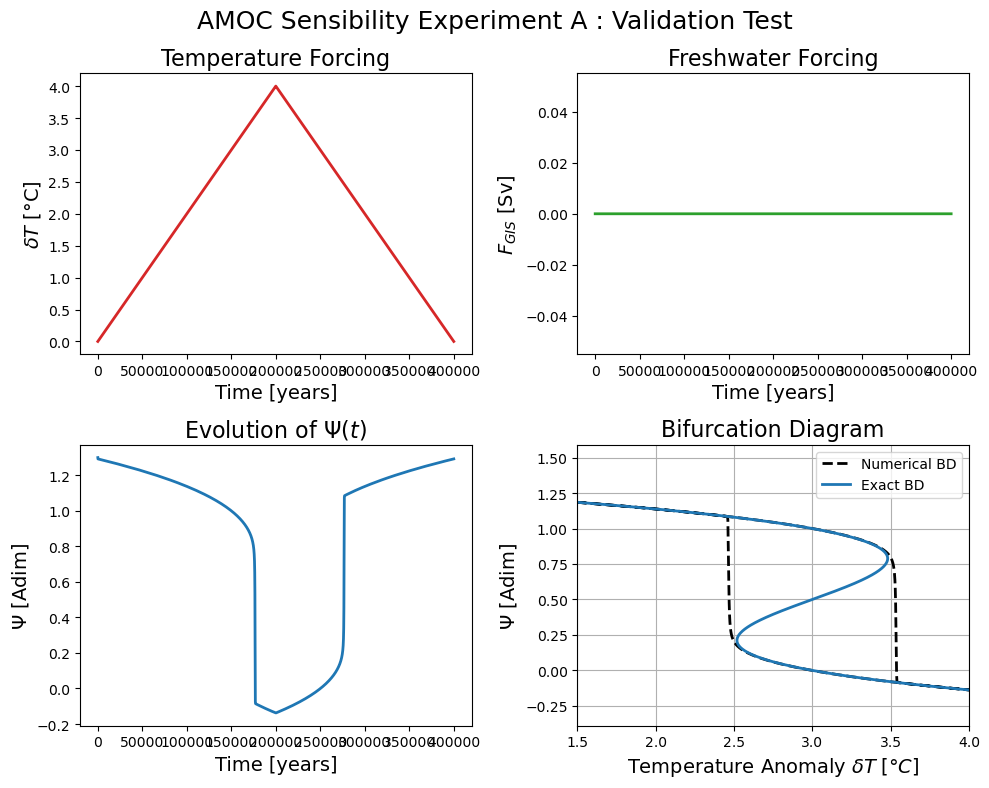

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
ax1, ax2, ax3, ax4 = axes.flatten()

fig.suptitle("AMOC Sensibility Experiment A : Validation Test", size=18)

ax1.plot(sol_ExpA.t, forcing_temperature(sol_ExpA.t), lw=2,color="tab:red")
ax1.set_title("Temperature Forcing", size=16)
ax1.set_xlabel("Time [years]", fontsize=14)
ax1.set_ylabel(r"$\delta T$ [°C]", fontsize=14)

ax2.plot(sol_ExpA.t, forcing_freshwater(sol_ExpA.t), lw=2,color="tab:green")
ax2.set_title("Freshwater Forcing", size=16)
ax2.set_xlabel("Time [years]", fontsize=14)
ax2.set_ylabel(r"$F_{GIS}$ [Sv]", fontsize=14)

ax3.plot(sol_ExpA.t, sol_ExpA.y[0], lw=2,color="tab:blue")
ax3.set_title("Evolution of " + r"$\Psi(t)$", size=16)
ax3.set_xlabel("Time [years]", fontsize=14)
ax3.set_ylabel(r"$\Psi$ [Adim]", fontsize=14)

ax4.plot(forcing_temperature(sol_ExpA.t), sol_ExpA.y[0], "k--", lw=2, label="Numerical BD")
ax4.plot(T,y_range,color="tab:blue", lw=2, label="Exact BD")
ax4.set_title("Bifurcation Diagram", size=16)
ax4.set_xlabel("Temperature Anomaly " + r"$\delta T \; [°C]$", fontsize=14)
ax4.set_ylabel(r"$\Psi$ [Adim]", fontsize=14)
ax4.set_xlim((1.5, 4))
ax4.grid()

plt.legend()
fig.tight_layout()
plt.savefig(figures_path+'val_test_EXPA', dpi=600, bbox_inches="tight")
plt.show()

### Step 3.1 - Computing associated critical values 

A first method which is also the easiest is to simply take the critical values visualy. 

Doing so we can roughly consider that :

- $\Psi^+ = 0.76$
- $\Psi^- = 0.245$
- $T^+ = 3.48°C$
- $T^- = 2.505°C$

A more rigourous method would be to use a numerical computation. 

### Step 2.2 - Producing Hysteresis Experiment B

Simulation parameters


In [16]:
t0 = 0  # year for the start of the simulation
tend = 400000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1.3]  # initial value

Parameterization of the forcing  

In [17]:
# Parameterization of the temperature forcing - T constant
T_cst = 0
forcing_temperature = interpolate.interp1d([t0,tend],[T_cst,T_cst],bounds_error= False, fill_value=0)

# Parameterization of the freshwater forcing 
F_forcing_max = 4
forcing_freshwater = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,F_forcing_max,0],bounds_error= False, fill_value=0)

Solver

In [18]:
sol_ExpB = solve_ivp(f, [t0, tend], y0, method="RK45", rtol=10**-6, t_eval=teval)

Analytical expression of the bifurcation diagram. We are "not supposed" to know that but it will be used to see if our simulations parameters are roughly good in order to retrive the exact bifurcation diagram. It will be also useful four the comparison with the bifurcation diagram of our simplified model.

In [19]:
y_range = np.linspace(-0.3,1.5,1000)
F = (y_range**3-a1_star*y_range**2-b1_star*y_range-c1_star-d1_star*T_cst)/e12_star

Plot

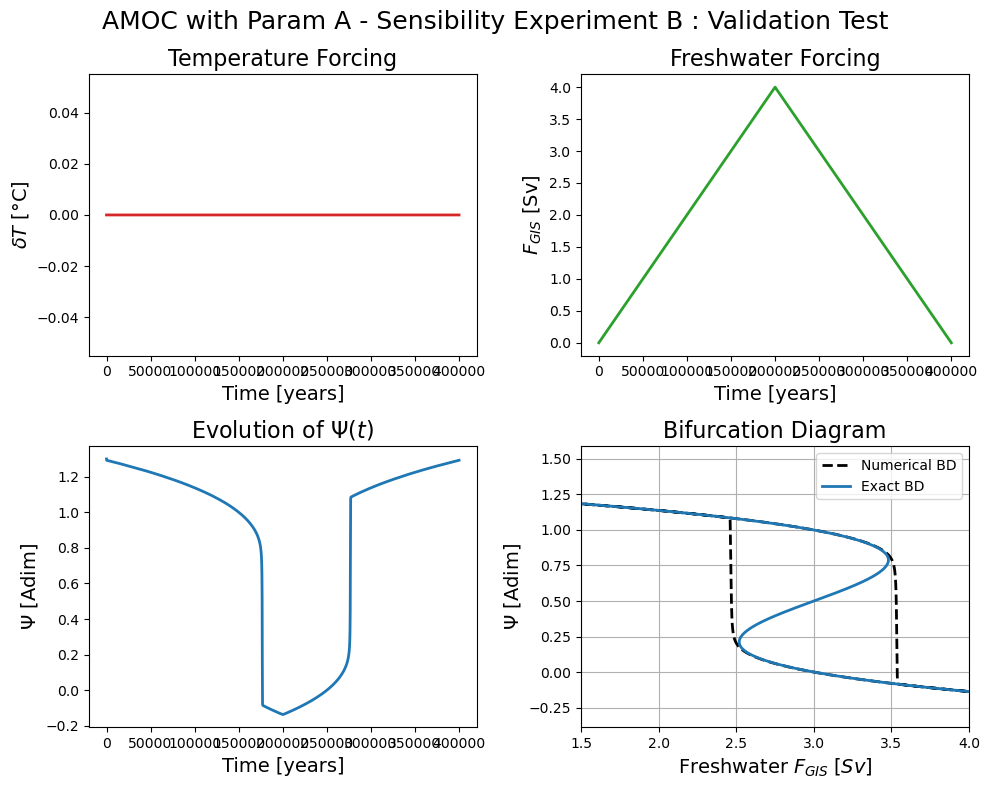

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
ax1, ax2, ax3, ax4 = axes.flatten()

fig.suptitle("AMOC with Param A - Sensibility Experiment B : Validation Test", size=18)

ax1.plot(sol_ExpB.t, forcing_temperature(sol_ExpB.t), lw=2, color="tab:red")
ax1.set_title("Temperature Forcing", size=16)
ax1.set_xlabel("Time [years]", size=14)
ax1.set_ylabel(r"$\delta T$ [°C]", size=14)

ax2.plot(sol_ExpB.t, forcing_freshwater(sol_ExpB.t), lw=2, color="tab:green")
ax2.set_title("Freshwater Forcing", size=16)
ax2.set_xlabel("Time [years]", size=14)
ax2.set_ylabel(r"$F_{GIS}$ [Sv]", size=14)

ax3.plot(sol_ExpB.t, sol_ExpB.y[0], lw=2, color="tab:blue")
ax3.set_title("Evolution of " + r"$\Psi(t)$", size=16)
ax3.set_xlabel("Time [years]", size=14)
ax3.set_ylabel(r"$\Psi$ [Adim]", size=14)

ax4.plot(forcing_freshwater(sol_ExpB.t), sol_ExpB.y[0], "k--", lw=2, label="Numerical BD")
ax4.plot(F,y_range,color="tab:blue", lw=2, label="Exact BD")
ax4.set_title("Bifurcation Diagram", size=16)
ax4.set_xlabel("Freshwater " + r"$F_{GIS} \; [Sv]$", size=14)
ax4.set_ylabel(r"$\Psi$ [Adim]", size=14)
ax4.set_xlim((1.5, 4))
ax4.grid()

plt.legend()
fig.tight_layout()
plt.savefig(figures_path+'val_test_EXPB', dpi=600, bbox_inches="tight")
plt.show()

### Step 3.2 - Computing associated critical values 

A first method which is also the easiest is to simply take the critical values visualy. 

Doing so we can roughly consider that :

- $\Psi^+ = 0.76$
- $\Psi^- = 0.245$
- $F_{GIS}^+ = 3.48 Sv$
- $F_{GIS}^- = 2.505Sv$

A more rigourous method is to use a numerical computation. 

### Step 4 - Computating of the calibrated coefficient based on the module

Now based on the critical bifurcations points coordinates from the two hysteres experiment we will "forgot" from which model them comes and only use the coordinates. We want to set those coordinates as input of our calibration algorithm and see if we can retrieve the "forgoten" coefficients. 

In [21]:
valid_test_AMOC_crit_params = [0.76,0.245,3.48,2.505,3.48,2.505,50,50]
valid_test_calib_coef = calib_module_AMOC(valid_test_AMOC_crit_params[0], valid_test_AMOC_crit_params[1], valid_test_AMOC_crit_params[2], valid_test_AMOC_crit_params[3], valid_test_AMOC_crit_params[4], valid_test_AMOC_crit_params[5], F_cst, T_cst)

a_AMOC = valid_test_calib_coef[0]
b_AMOC = valid_test_calib_coef[1]
c_AMOC = valid_test_calib_coef[5]
c_bis = valid_test_calib_coef[4]
d_AMOC = valid_test_calib_coef[2]
e_AMOC = valid_test_calib_coef[3]

### Step 5 - Comparison between initial data and simplified model

#### Coefficient comparison

In [22]:
## Global error computation ## 
err = np.sqrt((a1_star-a_AMOC)**2 + (b1_star-b_AMOC)**2 + (c1_star-c_AMOC)**2 + (d1_star-d_AMOC)**2 + (e12_star-e_AMOC)**2)

## Output ##
print("-----------------------------------------------------------")
print("Original arbitrarily fixed coefficient values")
print("-----------------------------------------------------------")
print("a_star = {:.3f}".format(a1_star))
print("b_star = {:.3f}".format(b1_star))
print("c_star = {:.3f}".format(c1_star))
print("d_star = {:.3f}".format(d1_star))
print("e_star = {:.3f}".format(e12_star))
print("-----------------------------------------------------------")
print("Calibrated coefficient values")
print("-----------------------------------------------------------")
print("a = {:.3f}".format(a_AMOC))
print("b = {:.3f}".format(b_AMOC))
print("c = {:.3f}".format(c_AMOC))
print("c_bis = {:.3f}".format(c_bis))
print("d = {:.3f}".format(d_AMOC))
print("e = {:.3f}".format(e_AMOC))
print("------------------------------------------------------------------")
print("Global error between initial and calibrated coeficients = {:.3f}".format(err))
print("Error on coef a = {:.2f}%".format(np.abs(((a_AMOC-a1_star)/a_AMOC))*100))
print("Error on coef b = {:.2f}%".format(np.abs(((b_AMOC-b1_star))/b_AMOC)*100))
print("Error on coef c = {:.2f}%".format(np.abs(((c_AMOC-c1_star))/c_AMOC)*100))
print("Error on coef d = {:.2f}%".format(np.abs(((d_AMOC-d1_star))/d_AMOC)*100))
print("Error on coef e = {:.2f}%".format(np.abs(((e_AMOC-e12_star))/e_AMOC)*100))
print("------------------------------------------------------------------")

-----------------------------------------------------------
Original arbitrarily fixed coefficient values
-----------------------------------------------------------
a_star = 1.500
b_star = -0.500
c_star = 0.300
d_star = -0.100
e_star = -0.100
-----------------------------------------------------------
Calibrated coefficient values
-----------------------------------------------------------
a = 1.507
b = -0.559
c = 0.237
c_bis = 0.237
d = -0.070
e = -0.070
------------------------------------------------------------------
Global error between initial and calibrated coeficients = 0.096
Error on coef a = 0.50%
Error on coef b = 10.49%
Error on coef c = 26.83%
Error on coef d = 42.76%
Error on coef e = 42.76%
------------------------------------------------------------------


#### Bifurcation Diagram comparison

Computation of the analytic bifurcation diagram for temperature based on the calibration module

In [23]:
T_calib_module = (y_range**3-a_AMOC*y_range**2-b_AMOC*y_range-c_AMOC-e_AMOC*F_cst)/d_AMOC

Plot

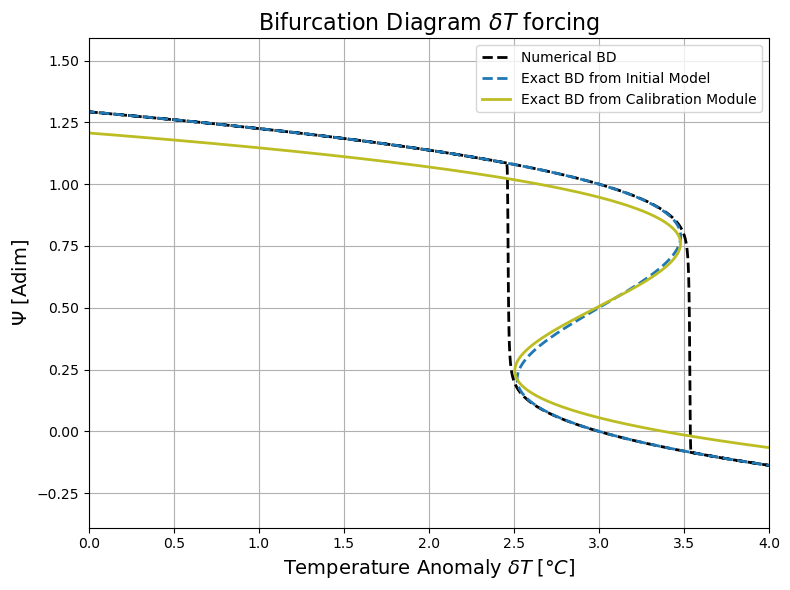

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

forcing_temperature = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,T_forcing_max,0],bounds_error= False, fill_value=0)

ax.plot(forcing_temperature(sol_ExpA.t), sol_ExpA.y[0], "k--", lw=2, label="Numerical BD")
ax.plot(T,y_range,'--',color="tab:blue", lw=2, label="Exact BD from Initial Model")
ax.plot(T_calib_module,y_range,color="tab:olive", lw=2, label="Exact BD from Calibration Module")
ax.set_title("Bifurcation Diagram " + r"$\delta T $ forcing", size=16)
ax.set_xlabel("Temperature Anomaly " + r"$\delta T \; [°C]$", fontsize=14)
ax.set_ylabel(r"$\Psi$ [Adim]", fontsize=14)
ax.set_xlim((0, 4))
ax.grid()

plt.legend()
fig.tight_layout()
plt.savefig(figures_path+'val_test_bif_diag_temp', dpi=600, bbox_inches="tight")
plt.show()

Computation of the analytic bifurcation diagram for freshwater based on the calibration module

In [25]:
F_calib_module = (y_range**3-a_AMOC*y_range**2-b_AMOC*y_range-c_AMOC-d_AMOC*T_cst)/e_AMOC

Plot

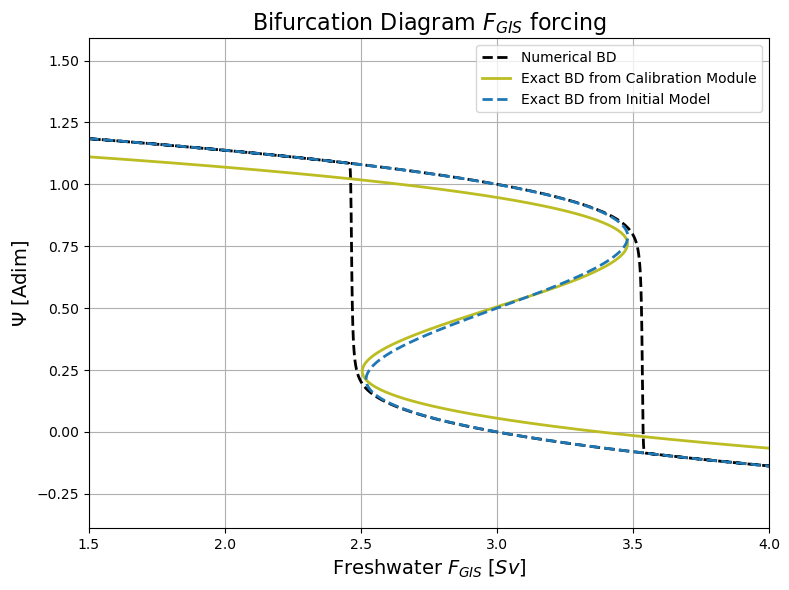

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(forcing_freshwater(sol_ExpB.t), sol_ExpB.y[0], "k--", lw=2, label="Numerical BD")
ax.plot(F_calib_module,y_range,color="tab:olive", lw=2, label="Exact BD from Calibration Module")
ax.plot(F,y_range,'--',color="tab:blue", lw=2, label="Exact BD from Initial Model")
ax.set_title("Bifurcation Diagram " + r"$F_{GIS} $ forcing", size=16)
ax.set_xlabel("Freshwater " + r"$F_{GIS} \; [Sv]$", size=14)
ax.set_ylabel(r"$\Psi$ [Adim]", size=14)
ax.set_xlim((1.5, 4))
ax.grid()

plt.legend()
fig.tight_layout()
plt.savefig(figures_path+'val_test_bif_diag_flux', dpi=600, bbox_inches="tight")
plt.show()

---
## cGenie Emulation
---



Two cGenie experiments have been perform by Justin Gérard in order to calibrate the ATCM on it. These experiments are available on the Zenodo link on the GitHub. 

The goal of those experiments is to produce the complex bifurcation diagram coming from an EMIC and to retrieve critical bifurcation coordinates on which I will calibrate the ATCM and then implement in SURFER.

The goal from the experiments made with cGenie is to retrieve the critical coordinates,

$$  \left\{(\Psi^+, T^+), (\Psi^-, T^-), (\Psi^+, F_{GIS}^+), (\Psi^-, F_{GIS}^-)\right \} $$

### Experiment Design of the Calibration Experiments

#### 1. Calibration of $a_1,b_1,c_1,d_1,e_{12}$

The experiments are the following :

- **EXPA = Bifurcation experiment with a $CO_2$ forcing** and constant freshwater forcing.
    - In our module we force the AMOC with a temperature forcing over 20 000 years but spanning $CO_2$ concentration from $280\; ppm$ up to $2800 \; ppm$ . We can find then a relation to convert a forcing in $CO_2$ into a forcing in temperature. 
- **EXPB = Bifurcation experiment with a parameterize $F_{GIS}$ forcing** and constant $CO_2$ forcing.
    - Hosing experiment from $0 \; Sv$ to $0.2 \; Sv$ over 20 000 years injected between 50°N and 70°N and 45°W and 5°E in order to mimic a GIS melting effect with constant salinity over the global ocean.

#### 2. Calibration of $\tau$

- **EXPC = Internal time scale calibration experiment.**
    - A 10,000-year experiment was conducted using cGenie with a fixed $CO_2$ concentration but with incremental increases and decreases in freshwater flux in steps of $0.05;Sv$. The aim was to observe the characteristic response time of the AMOC in cGenie and to calibrate the $\tau$ parameter of the AMOC in the ATCM accordingly.


---

### Directories Setup

In [27]:
################################# Personnal data path #####################################

base_path_cGenie_sim = os.path.join(base_path,'data\\cGenie simulations\\Paper Simulations')

### Calibration Experiments ###

personal_data_path_ExpA = os.path.join(base_path_cGenie_sim,'JG.worjh2.T_collapse.SPIN\\biogem\\')
personal_data_path_ExpB = os.path.join(base_path_cGenie_sim,'JG.worjh2.fw_collapse.SPIN\\biogem\\')
personal_data_path_ExpC = os.path.join(base_path_cGenie_sim,'JG.worjh2.fw_zigzag.SPIN\\biogem\\')
### Validtion Experiments ###

personal_data_path_val_exp_1 = os.path.join(base_path_cGenie_sim,'JG.worjh2.hybrid_collapse.SPIN\\biogem\\')

###################################### Reading data ######################################

############################# Exp A ##################################

## CO2 Forcing ## 
forcing_CO_2 = pd.read_table(personal_data_path_ExpA+"biogem_series_atm_pCO2_mod.res",header=1,sep=",")
global_pCO2 = forcing_CO_2["0.279723E-03"]
year_ExpA = forcing_CO_2["0.500"]
time_ramp_up_ExpA = year_ExpA[0:499]
time_ramp_down_ExpA = year_ExpA[498:]

## Temperature Forcing ## 
forcing_temp = pd.read_table(personal_data_path_ExpA+"biogem_series_atm_temp.res", header=1, sep=",")
global_sat = forcing_temp["12.302803"]

## Oceanic Temperature ## 

ocn_temp_data_ExpA = pd.read_table(personal_data_path_ExpA+'biogem_series_ocn_temp.res',header=1,sep=',')
ocn_temp_ExpA = ocn_temp_data_ExpA["3.520206"]

## Oceanic Salinity ## 

ocn_sal_data_ExpA = pd.read_table(personal_data_path_ExpA+'biogem_series_ocn_sal.res',header=1,sep=',')
ocn_sal_ExpA = ocn_sal_data_ExpA["34.900945"]

## Global and Atlantic Overturning Circulation ## 

opsi_ExpA = pd.read_table(personal_data_path_ExpA+"biogem_series_misc_opsi.res",header=1,sep=",")
glob_min_overt_ExpA = opsi_ExpA["-35.595"]
glob_max_overt_ExpA = opsi_ExpA["37.663"]
atl_min_overt_ExpA = opsi_ExpA["-0.653"]
atl_max_overt_ExpA = opsi_ExpA["14.329"]

## Normalisation of the intensity ##
norm_atl_max_overt_ExpA = atl_max_overt_ExpA/max(atl_max_overt_ExpA)

############################# Exp B ##################################

## Oceanic Temperature ## 

ocn_temp_data_ExpB = pd.read_table(personal_data_path_ExpB+'biogem_series_ocn_temp.res',header=1,sep=',')
year_ExpB = ocn_temp_data_ExpB["0.500"]
time_ramp_up_ExpB = year_ExpA[0:451]
time_ramp_down_ExpB = year_ExpA[450:]
ocn_temp_ExpB = ocn_temp_data_ExpB["3.520169"]

## Oceanic Salinity ## 

ocn_sal_data_ExpB = pd.read_table(personal_data_path_ExpB+'biogem_series_ocn_sal.res',header=1,sep=',')
ocn_sal_ExpB = ocn_sal_data_ExpB["34.900945"]

## Temperature response ## 

atm_temp_ExpB = pd.read_table(personal_data_path_ExpB+"biogem_series_atm_temp_mod.res",header=1,sep=',')
global_sat_ExpB = atm_temp_ExpB["12.299055"]

## Global and Atlantic Overturning Circulation ## 

opsi_ExpB = pd.read_table(personal_data_path_ExpB+"biogem_series_misc_opsi.res",header=1,sep=",")
glob_min_overt_ExpB = opsi_ExpB["-35.596"]
glob_max_overt_ExpB = opsi_ExpB["37.664"]
atl_min_overt_ExpB = opsi_ExpB["-0.653"]
atl_max_overt_ExpB = opsi_ExpB["14.329"]

## Normalisation of the intensity ##
norm_atl_max_overt_ExpB = atl_max_overt_ExpB/max(atl_max_overt_ExpB)

############################# Exp C ##################################

## Global and Atlantic Overturning Circulation ## 

opsi_ExpC = pd.read_table(personal_data_path_ExpC+"biogem_series_misc_opsi.res",header=1,sep=",")
year_ExpC = opsi_ExpC["0.500"]
glob_min_overt_ExpC = opsi_ExpC["-35.596"]
glob_max_overt_ExpC = opsi_ExpC["37.664"]
atl_min_overt_ExpC = opsi_ExpC["-0.653"]
atl_max_overt_ExpC = opsi_ExpC["14.329"]

## Normalisation of the intensity ##
norm_atl_max_overt_ExpC = atl_max_overt_ExpC/max(atl_max_overt_ExpC)

############################# val_exp_1 ##################################

## CO2 Forcing ## 
forcing_CO_2_val_exp_1 = pd.read_table(personal_data_path_val_exp_1+"biogem_series_atm_pCO2.res",header=1,sep=",")
global_pCO2 = forcing_CO_2_val_exp_1["0.279723E-03"]
year_val_exp_1 = forcing_CO_2_val_exp_1["0.500"]

## Temperature Forcing ## 
forcing_temp_val_exp_1 = pd.read_table(personal_data_path_val_exp_1+"biogem_series_atm_temp.res", header=1, sep=",")
global_sat_val_exp_1 = forcing_temp_val_exp_1["12.302803"]

## Global and Atlantic Overturning Circulation ## 

opsi_val_exp_1 = pd.read_table(personal_data_path_val_exp_1+"biogem_series_misc_opsi.res",header=1,sep=",")
glob_min_overt_val_exp_1 = opsi_val_exp_1["-35.595"]
glob_max_overt_val_exp_1 = opsi_val_exp_1["37.663"]
atl_min_overt_val_exp_1 = opsi_val_exp_1["-0.653"]
atl_max_overt_val_exp_1 = opsi_val_exp_1["14.329"]

## Normalisation of the intensity ##
norm_atl_max_overt_val_exp_1 = atl_max_overt_val_exp_1/max(atl_max_overt_val_exp_1)



---
### cGenie simulations analysis
---

#### EXPA - $CO_2$ Sensibility Experiment


##### $CO_2$ forcing

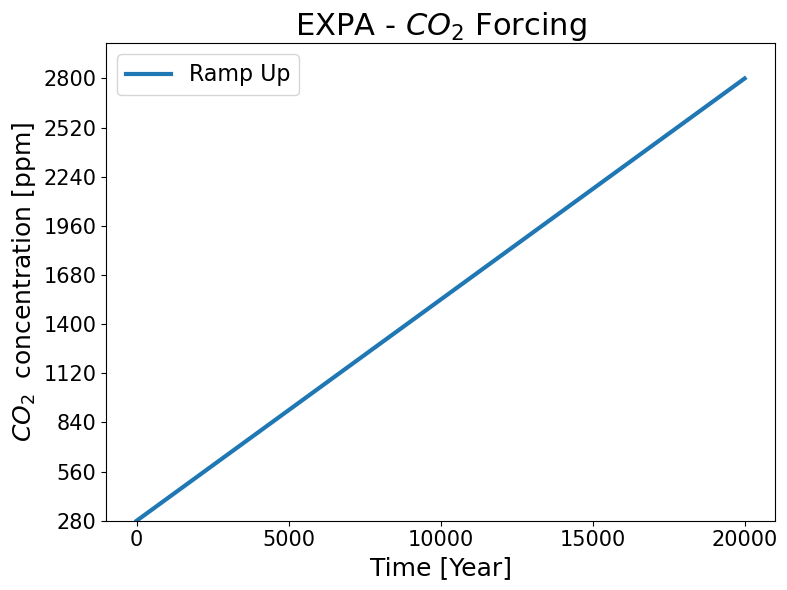

In [28]:
### Forcing parameterization ###

t_pi= 0
t_0 = 0
t_end = 20000
co2_min = 280
co2_max = 2800

time_ramp_up = np.arange(t_0,t_end,1)
time = np.arange(t_0,t_end,1)


co2_ramp_up = interpolate.interp1d([t_0,t_end],[co2_min,co2_max],bounds_error= False, fill_value=0)
co2_ramp_up_forcing = co2_ramp_up(time_ramp_up)

### Plot ###

plt.figure(figsize=(8,6))
plt.plot(time_ramp_up,co2_ramp_up_forcing,label='Ramp Up',lw=3)
#plt.plot(year_ExpA, global_pCO2*1e6)
plt.title("EXPA - " + r"$CO_{2}$"+" Forcing",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel(r"$CO_2\;$ concentration [ppm]",fontsize=18)
plt.ylim(280,3000)
plt.yticks(np.arange(280, 3000, step=280))
plt.xticks(np.arange(0,25000, step=5000))
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(figures_path+'EXPA_CO2_forcing',dpi=500)
plt.show()

##### Temperature forcing

In [29]:
### Computation of the global surface temperature anomaly ###
eq_temp_cGenie = global_sat[0]
global_sat_anomaly_cGenie = global_sat - eq_temp_cGenie
print("Equilibrium initial surface temperature : {} °C".format(eq_temp_cGenie))
print("Equilibrium initial surface temperature anomaly : {} °C".format(global_sat_anomaly_cGenie))


Equilibrium initial surface temperature : 12.306488 °C
Equilibrium initial surface temperature anomaly : 0       0.000000
1       0.002838
2       0.005654
3       0.006673
4       0.009191
         ...    
494    10.095188
495    10.137427
496    10.179507
497    10.221454
498    10.262805
Name: 12.302803, Length: 499, dtype: float64 °C


In [30]:
print(year_ExpA)

0          1.5
1          2.5
2          3.5
3          4.5
4          5.5
        ...   
494    19199.5
495    19399.5
496    19599.5
497    19799.5
498    19999.5
Name: 0.500, Length: 499, dtype: float64


In [31]:
print(global_sat_anomaly_cGenie)

0       0.000000
1       0.002838
2       0.005654
3       0.006673
4       0.009191
         ...    
494    10.095188
495    10.137427
496    10.179507
497    10.221454
498    10.262805
Name: 12.302803, Length: 499, dtype: float64


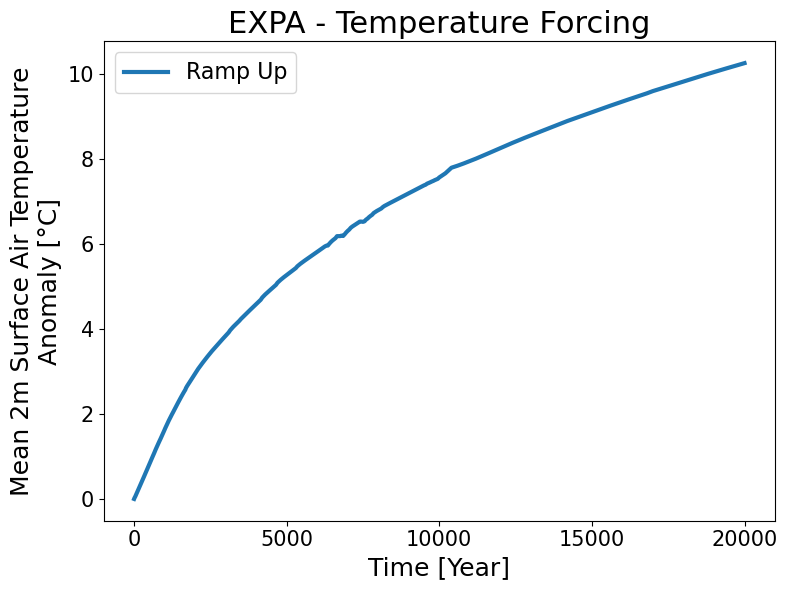

In [32]:
plt.figure(figsize=(8,6))
plt.plot(year_ExpA,global_sat_anomaly_cGenie,label='Ramp Up',lw=3)
plt.title("EXPA - Temperature Forcing",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel("Mean 2m Surface Air Temperature\nAnomaly [°C]",fontsize=18)
plt.xticks(np.arange(0,25000, step=5000))
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.savefig(figures_path+'EXPA_Temp_forcing_anomaly',dpi=500)
plt.legend(fontsize=16)
plt.show()

##### Global oceanic temperature and salinity

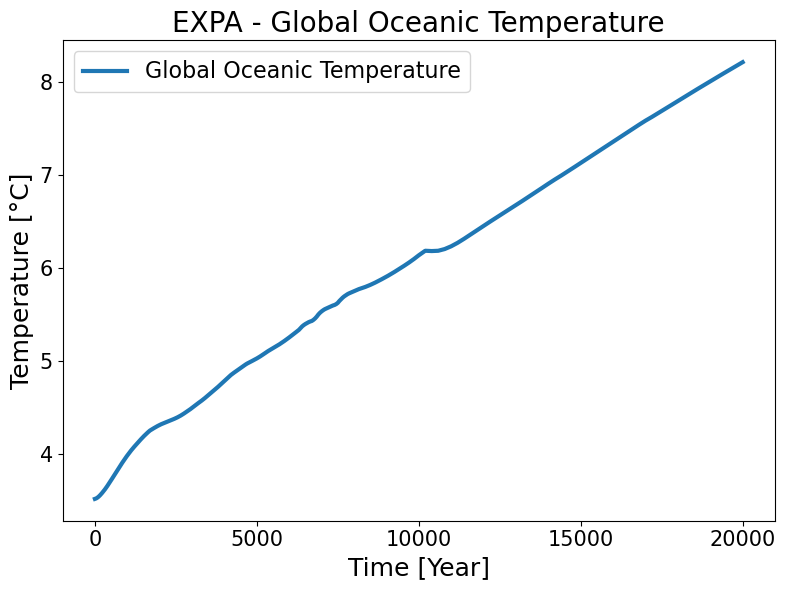

In [33]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(year_ExpA, ocn_temp_ExpA,label='Global Oceanic Temperature',color="tab:blue",lw=3)
ax1.set_xlabel("Time [Year]",fontsize=18)
ax1.set_ylabel("Temperature [°C]",fontsize=18)
plt.legend(fontsize=16)
plt.tick_params(axis='both',labelsize=15)
plt.tick_params(axis='both',labelsize=15)
plt.title("EXPA - Global Oceanic Temperature",fontsize=20)
plt.legend(fontsize=16)
plt.xticks(np.arange(0,25000, step=5000))
plt.tight_layout()
plt.savefig(figures_path+'EXPA_Glob_Temp',dpi=500)
plt.show()

##### Global Min/Max Overtuning Atlantic Overturning circulation

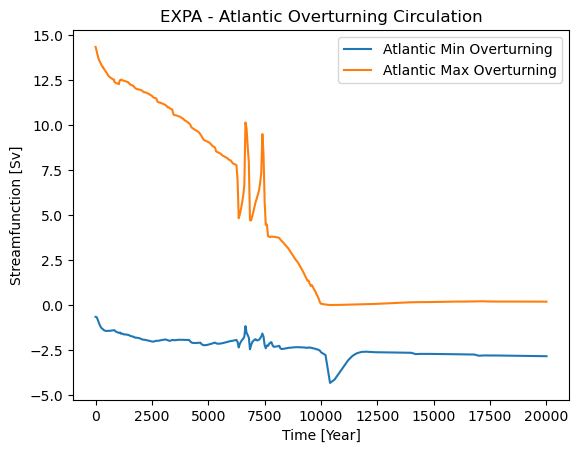

In [34]:
plt.plot(year_ExpA, atl_min_overt_ExpA,label='Atlantic Min Overturning')
plt.plot(year_ExpA, atl_max_overt_ExpA,label='Atlantic Max Overturning')
plt.title("EXPA - Atlantic Overturning Circulation")
plt.xlabel("Time [Year]")
plt.ylabel("Streamfunction [Sv]")
plt.legend()
plt.savefig(figures_path+'EXPA_Atl_Overt_Circ_MinMax',dpi=500)
plt.show()

##### Bifurcation Diagram

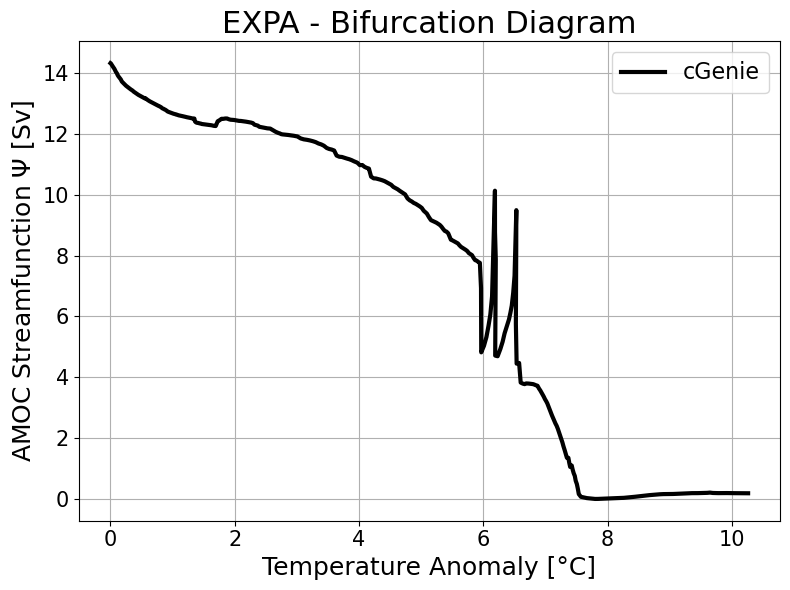

In [35]:
plt.figure(figsize=(8,6))
plt.plot(global_sat_anomaly_cGenie, atl_max_overt_ExpA,label='cGenie',lw=3,color="black")
plt.title("EXPA - Bifurcation Diagram",fontsize=22)
plt.xlabel("Temperature Anomaly [°C]",fontsize=18)
plt.ylabel("AMOC Streamfunction " + r'$\Psi$ ' + "[Sv]",fontsize=18)
plt.legend(fontsize=16)
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.grid()
plt.savefig(figures_path+'EXPA_bif_diag',dpi=400)
plt.show()

#### EXPB - $F_{GIS}$ Sensibility Experiment

##### $F_{GIS}$ forcing

We can manualy reconstruct the hosing forcing. Justin Gérard's experimental protocol shares the following parameterization.

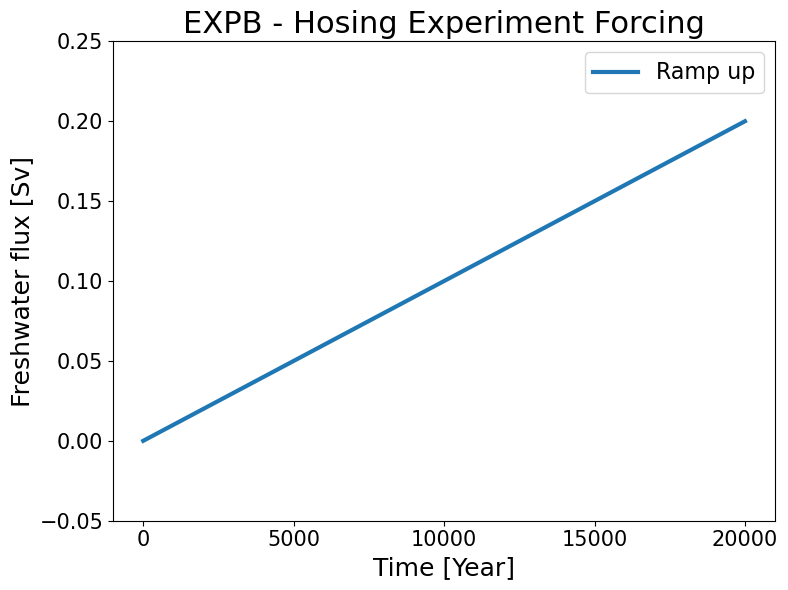

In [36]:
### Construction of the Hosing Profile ###
t_0 = 0
t_f = 20000
hosing_min = 0
hosing_max = 0.2

time_ramp_up = np.arange(t_0,t_f,1)
time = np.arange(t_0,t_f,1)

freshwater_flux_ramp_up_hosing = interpolate.interp1d([t_0,t_f],[hosing_min,hosing_max],bounds_error= False, fill_value=0)
frswat_flux_ramp_up = freshwater_flux_ramp_up_hosing(time_ramp_up)

### Plotting ### 

plt.figure(figsize=(8,6))
plt.plot(time_ramp_up,frswat_flux_ramp_up, label='Ramp up',lw=3)
plt.title("EXPB - Hosing Experiment Forcing",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel("Freshwater flux [Sv]",fontsize=18)
plt.ylim(-0.05,0.25)
plt.legend(fontsize=16)
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.xticks(np.arange(0,25000, step=5000))
plt.savefig(figures_path+'EXPB_F_forcing',dpi=400)
plt.show()

##### Global oceanic temperature and salinity

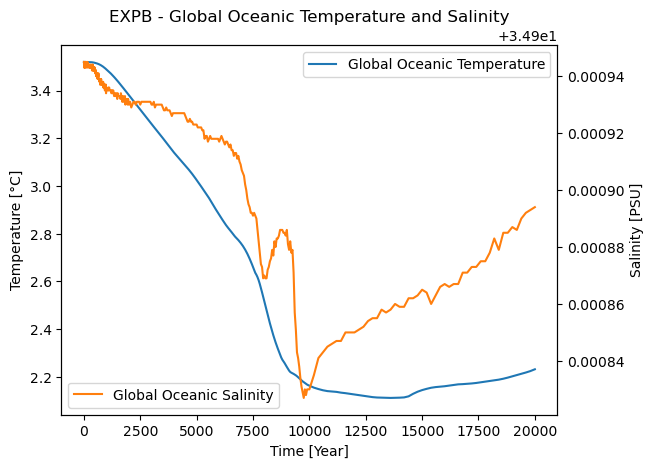

In [37]:
fig, ax1 = plt.subplots()

ax1.plot(year_ExpB, ocn_temp_ExpB,label='Global Oceanic Temperature',color="tab:blue")
ax1.set_xlabel("Time [Year]")
ax1.set_ylabel("Temperature [°C]")
plt.legend()

ax2 = ax1.twinx()

ax2.plot(year_ExpB, ocn_sal_ExpB,label='Global Oceanic Salinity',color="tab:orange")
ax2.set_ylabel("Salinity [PSU]")

plt.title("EXPB - Global Oceanic Temperature and Salinity")
plt.legend(loc='lower left')
plt.savefig(figures_path+'EXPB_Glob_Temp_and_Sal')

plt.show()

##### Global Min/Max Overtuning Atlantic Overturning circulation

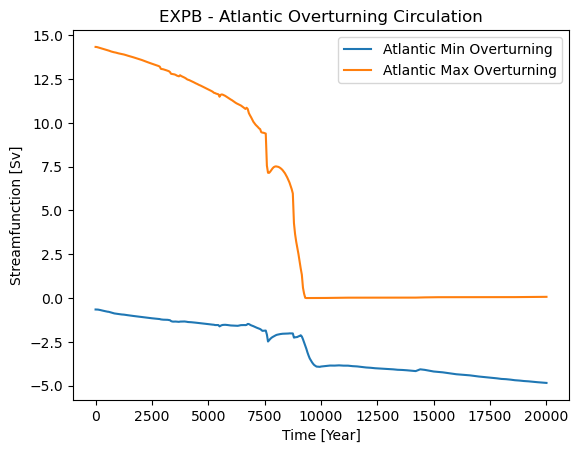

In [38]:
plt.plot(year_ExpB, atl_min_overt_ExpB,label='Atlantic Min Overturning')
plt.plot(year_ExpB, atl_max_overt_ExpB,label='Atlantic Max Overturning')
plt.title("EXPB - Atlantic Overturning Circulation")
plt.xlabel("Time [Year]")
plt.ylabel("Streamfunction [Sv]")
plt.legend()
plt.savefig(figures_path+'EXPB_Atl_Overt_Circ_MinMax')
plt.show()

##### Bifurcation Diagram

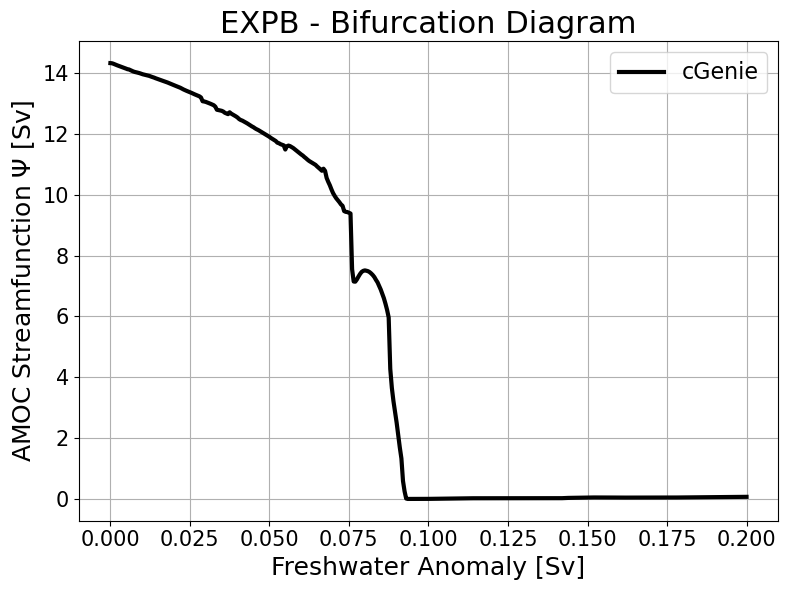

In [39]:
### Hosing Forcing Interpolation ###
hosing_forcing_it = np.interp(year_ExpB, np.arange(t_0,t_f,1), frswat_flux_ramp_up)

### Plot ###
plt.figure(figsize=(8,6))
plt.plot(hosing_forcing_it,atl_max_overt_ExpB,label='cGenie',lw=3,color="black")
plt.title("EXPB - Bifurcation Diagram",fontsize=22)
plt.xlabel("Freshwater Anomaly [Sv]",fontsize=18)
plt.ylabel("AMOC Streamfunction " + r'$\Psi$ ' + "[Sv]",fontsize=18)
plt.legend(fontsize=16)
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.grid()
plt.savefig(figures_path+'EXPB_bif_diag',dpi=400)
plt.show()

#### EXPC - $\tau$ sensitivity experiment

##### Freshwater flux forcing parameterization

We can manualy reconstruct the hosing forcing. Justin Gérard's experimental protocol shares the following parameterization.


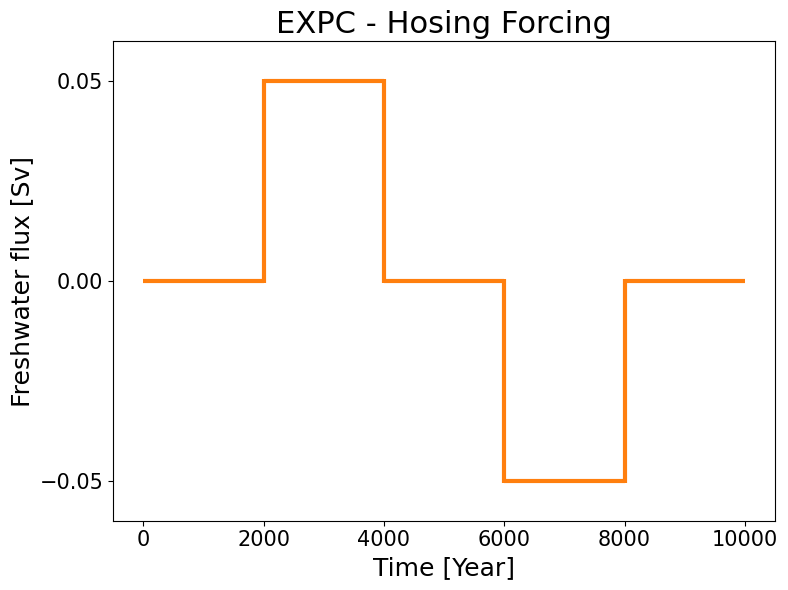

In [40]:
time_intervals = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000, 10000)]
FGIS_values = [0.0, 0.05, 0.0, -0.05, 0.0]  # En Sv

plt.figure(figsize=(8,6))

for (t_start, t_end), fgis in zip(time_intervals, FGIS_values):
    plt.hlines(y=fgis, xmin=t_start, xmax=t_end, linewidth=3,color="tab:orange")

plt.vlines(x=2000, ymin=-0.0005, ymax=0.0505, linewidth=3,color="tab:orange")
plt.vlines(x=4000, ymin=-0.0005, ymax=0.0505, linewidth=3,color="tab:orange")
plt.vlines(x=6000, ymax=0.0005, ymin=-0.0505, linewidth=3,color="tab:orange")
plt.vlines(x=8000, ymin=0.0005, ymax=-0.0505, linewidth=3,color="tab:orange")

plt.title("EXPC - Hosing Forcing",fontsize=22)
plt.xlabel("Time [Year]", fontsize=18)
plt.ylabel("Freshwater flux [Sv]", fontsize=18)
plt.yticks([-0.05, 0, 0.05])
plt.ylim(-0.06, 0.06)
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.savefig(figures_path+'EXPC_F_forcing',dpi=400)
plt.show()

##### AMOC Response 


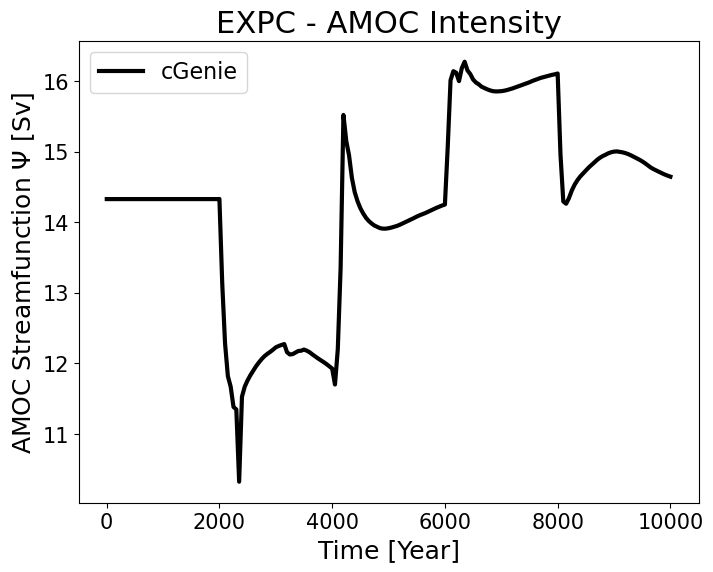

In [41]:
plt.figure(figsize=(8,6))
plt.plot(year_ExpC, atl_max_overt_ExpC,lw=3,color="black",label="cGenie")
plt.title("EXPC - AMOC Intensity",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel("AMOC Streamfunction " + r'$\Psi$ ' + "[Sv]",fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=16)
plt.savefig(figures_path+'EXPC_Atl_Overt_Circ_Max',dpi=500)
plt.show()

---
### ATCM calibration on cGenie

Now we want to calibrate the ATCM based on the cGenie experiments EXPA and EXPB. For that we will retrieve the coordinates of the bifurcation points in the complex simulations.  

Conversaly to the retrieval based on simplified model's hysteres it will be less easier in this case since the cGenie simulations are more complex because they are more processed based. 

We will still use visual jugement of the positions of those points but also  expert advice, particularly from J. Gérard, who is accustomed to working with cGenie and AMOC and has already conducted other sensitivity experiments to better identify the location of irreversible tipping points.

The calibration has two parts : 

1) Calibration of the $a_1,b_1,c_1,d_1,e_{12}$ coefficients in order to calibrate the internal dynamic and  of the AMOC and its coupling with the GIS.

2) Calibration of the typical time scale $\tau_\Psi$

---

#### 1. Calibration of the internal dynamic

To calibrate the $a_1,b_1,c_1,d_1,e_{12}$ coefficients we will find the best values of the coordinates of the bifurcation points and then apply the AGTCM algorithm.

##### Definition of the critical coordinates 

In [42]:
##### Definition of the critical values #####

### EXP A ###
Psip_ExpA = 0.545
Psim_ExpA = 0.0220 # exact value from old EXPA
Tp = 5.93
#Tm = 1.27 # exact value from old EXPA
Tm = 3 # best fit for EXPA with exact value of Psip and Tp

### EXP B ###
Psip_ExpB = 0.655 # best fit
Psim_ExpB = 0.16 # best fit
FGISp=0.075 # best fit 
#FGISm = 0.01 # best fit
FGISm = 0.037 # tuned best fit

##### Output #####
print("------------------------------------------------------------------------")
print("Critical values retrieved visualy based on the hysteresis experiment")
print("------------------------------------------------------------------------")
print("----------------------------")
print("Psip_ExpA = {:.3f}".format(Psip_ExpA))
print("Psim_ExpA = {:.3f}".format(Psim_ExpA))
print("Tp = {:.3f}".format(Tp))
print("Tm = {:.3f}".format(Tm))
print("----------------------------")
print("Pisp_ExpB = {:.3f}".format(Psip_ExpB))
print("Psim_ExpB = {:.3f}".format(Psim_ExpB))
print("FGISp = {:.3f}".format(FGISp))
print("FGISm = {:.3f}".format(FGISm))
print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Critical values retrieved visualy based on the hysteresis experiment
------------------------------------------------------------------------
----------------------------
Psip_ExpA = 0.545
Psim_ExpA = 0.022
Tp = 5.930
Tm = 3.000
----------------------------
Pisp_ExpB = 0.655
Psim_ExpB = 0.160
FGISp = 0.075
FGISm = 0.037
------------------------------------------------------------------------


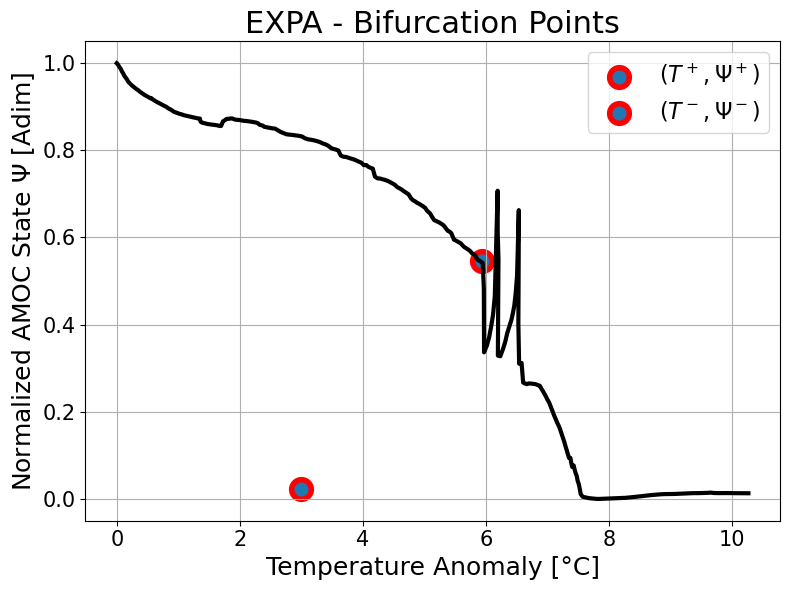

In [43]:
## Plot bifurcation diagram experiment A ## 
plt.figure(figsize=(8,6))
plt.plot(global_sat_anomaly_cGenie, norm_atl_max_overt_ExpA, color="black",lw=3)
plt.scatter(Tp, Psip_ExpA, marker='o', color="#1f77b4",linewidths=4,s=200, edgecolors="red", label=r"$(T^+, \Psi^+)$")
plt.scatter(Tm, Psim_ExpA, marker='o', color="#1f77b4",linewidths=4,s=200, edgecolors="red", label=r"$(T^-, \Psi^-)$")
plt.title("EXPA - Bifurcation Points",fontsize=22)
plt.xlabel("Temperature Anomaly [°C]",fontsize=18)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig(figures_path+'EXPA_bif_diag_bp',dpi=300)
plt.show()

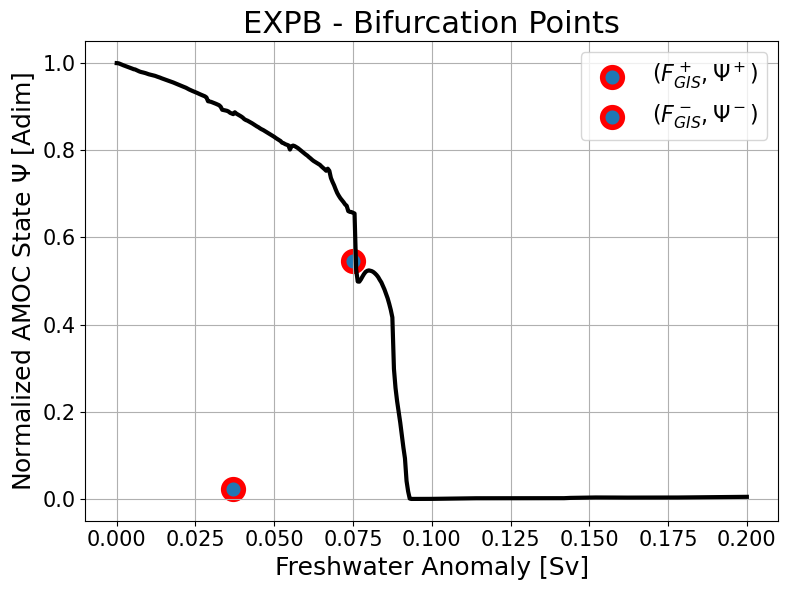

In [44]:
### Plot ### 
plt.figure(figsize=(8,6))
plt.plot(hosing_forcing_it,norm_atl_max_overt_ExpB,color='black',lw=3)
plt.scatter(FGISp, Psip_ExpA, marker='o', color="#1f77b4",linewidths=4,s=200, edgecolors="red", label=r"$(F_{GIS}^+, \Psi^+)$")
plt.scatter(FGISm, Psim_ExpA, marker='o', color="#1f77b4",linewidths=4,s=200, edgecolors="red", label=r"$(F_{GIS}^-, \Psi^-)$")
plt.title("EXPB - Bifurcation Points",fontsize=22)
plt.xlabel("Freshwater Anomaly [Sv]",fontsize=18)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig(figures_path+'EXPB_bif_diag_bp',dpi=300)
plt.show()

##### ATCM calibration

In [45]:
## Definition of the constant forcing values for the differents sensibility experiment ##

F_GIS_cst_A = 0
T_forcing_cst_B = 0

## Hypothesis of the mean of the critical value for the \Psi^{\pm} ##
hyp_mean_crit_val = False 

if hyp_mean_crit_val:
    Psip = (Psip_ExpA+Psip_ExpB+Psip_ExpC)/3
    Psim = (Psim_ExpA+Psim_ExpB+Psim_ExpC)/3
else:
    Psip = Psip_ExpA
    Psim = Psim_ExpA

## Definition of the all set of critical values and calibration ##

cGenie_crit_params = [Psip,Psim,Tp,Tm,FGISp,FGISm,50,50]
calib_coef = calib_module_AMOC(cGenie_crit_params[0], cGenie_crit_params[1], cGenie_crit_params[2], cGenie_crit_params[3], cGenie_crit_params[4], cGenie_crit_params[5],F_GIS_cst_A, T_forcing_cst_B)

a_AMOC = calib_coef[0]
b_AMOC = calib_coef[1]
c_AMOC = calib_coef[4]
c_bis = calib_coef[5]
d_AMOC = calib_coef[2]
e_AMOC = calib_coef[3]

print("-----------------------------------------------------------")
print("Calibrated coefficient values")
print("-----------------------------------------------------------")
print("a_1 = {:.3f}".format(a_AMOC))
print("b_1 = {:.3f}".format(b_AMOC))
print("c_1 = {:.3f}".format(c_AMOC))
print("c_bis1 = {:.3f}".format(c_bis))
print("d_1 = {:.3f}".format(d_AMOC))
print("e_12 = {:.3f}".format(e_AMOC))
print("------------------------------------------------------------------")

-----------------------------------------------------------
Calibrated coefficient values
-----------------------------------------------------------
a_1 = 0.851
b_1 = -0.036
c_1 = 0.074
c_bis1 = 0.070
d_1 = -0.024
e_12 = -1.882
------------------------------------------------------------------


Calibrated Hysteresis and Bifurcation Diagram

In [46]:
### Definition of the different branches of stability ###

def Tpsi_funct_psi(psi):
    return ((psi**3-a_AMOC*(psi**2)-b_AMOC*psi-c_AMOC-e_AMOC*F_GIS_cst_A)*(1/d_AMOC))
def FGIS_funct_psi(psi):
    return ((psi**3-a_AMOC*(psi**2)-b_AMOC*psi-c_AMOC-d_AMOC*T_forcing_cst_B)*(1/e_AMOC))

### Computations of unstables branches ###

N=1000
psi_range = np.linspace(0,1,N)
unstable_psi = np.linspace(cGenie_crit_params[1],cGenie_crit_params[0],N)

T_unstable = Tpsi_funct_psi(unstable_psi)
FGIS_unstable = FGIS_funct_psi(unstable_psi)

# Computation of the analytical bifurcation diagram of the simplified model
T_calib_module = (psi_range**3-a_AMOC*psi_range**2-b_AMOC*psi_range-c_AMOC-e_AMOC*F_GIS_cst_A)/d_AMOC
F_GIS_calib_module = (psi_range**3-a_AMOC*psi_range**2-b_AMOC*psi_range-c_AMOC-d_AMOC*T_forcing_cst_B)/e_AMOC

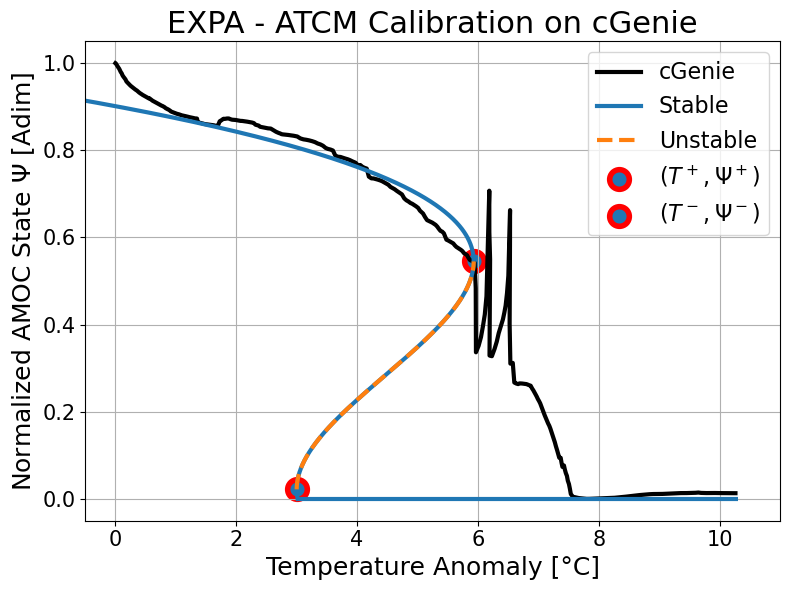

In [47]:
## Plot bifurcation diagram experiment A ## 
plt.figure(figsize=(8,6))

plt.plot(global_sat_anomaly_cGenie, norm_atl_max_overt_ExpA, color="black",label='cGenie',lw=3)
plt.plot(T_calib_module,psi_range,color='tab:blue',label='Stable',lw=3)
plt.plot(T_unstable,unstable_psi,color='tab:orange',linestyle='dashed',label='Unstable',lw=3)
plt.hlines(y=0, xmin=3, xmax=10.3, color='tab:blue', linewidth=3)

plt.scatter(Tp, Psip, marker='o', color="#1f77b4",linewidths=4,s=200,edgecolors="red", label=r"$(T^+, \Psi^+)$")
plt.scatter(Tm, Psim, marker='o', color="#1f77b4",linewidths=4,s=200,edgecolors="red", label=r"$(T^-, \Psi^-)$")


plt.title("EXPA - ATCM Calibration on cGenie",fontsize=22)
plt.xlabel("Temperature Anomaly [°C]",fontsize=18)
plt.xlim(-0.5,11)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(figures_path+'EXPA_emu_bif_diag_bp',dpi=400)
plt.show()

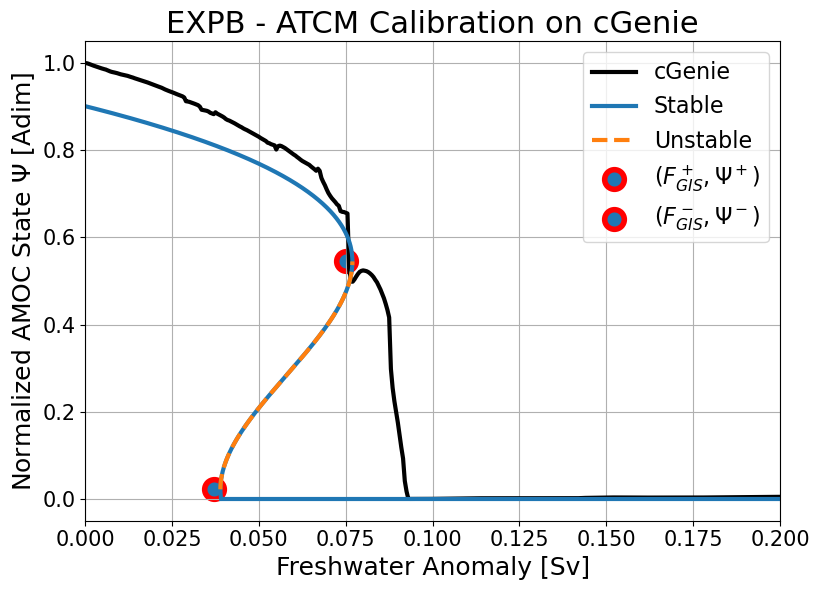

In [48]:
### Plot ### 
plt.figure(figsize=(8,6))

plt.plot(hosing_forcing_it,norm_atl_max_overt_ExpB,color='black',label='cGenie',lw=3)
plt.plot(F_GIS_calib_module,psi_range,color='tab:blue',label='Stable',lw=3)
plt.plot(FGIS_unstable,unstable_psi,color='tab:orange',linestyle='dashed',label='Unstable',lw=3)
plt.hlines(y=0, xmin=0.039, xmax=0.2, color='tab:blue', linewidth=3)

plt.scatter(FGISp, Psip_ExpA, marker='o', color="#1f77b4",linewidths=4,s=200, edgecolors="red", label=r"$(F_{GIS}^+, \Psi^+)$")
plt.scatter(FGISm, Psim_ExpA, marker='o', color="#1f77b4",linewidths=4,s=200, edgecolors="red", label=r"$(F_{GIS}^-, \Psi^-)$")


plt.title("EXPB - ATCM Calibration on cGenie",fontsize=22)
plt.xlabel("Freshwater Anomaly [Sv]",fontsize=18)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=16)
plt.xlim(0,0.2)
plt.savefig(figures_path+'EXPB_emu_bif_diag_bp',dpi=400)
plt.show()

Differences between Exact Tipping Point Locations and Tipping Point Locations in the Emulator

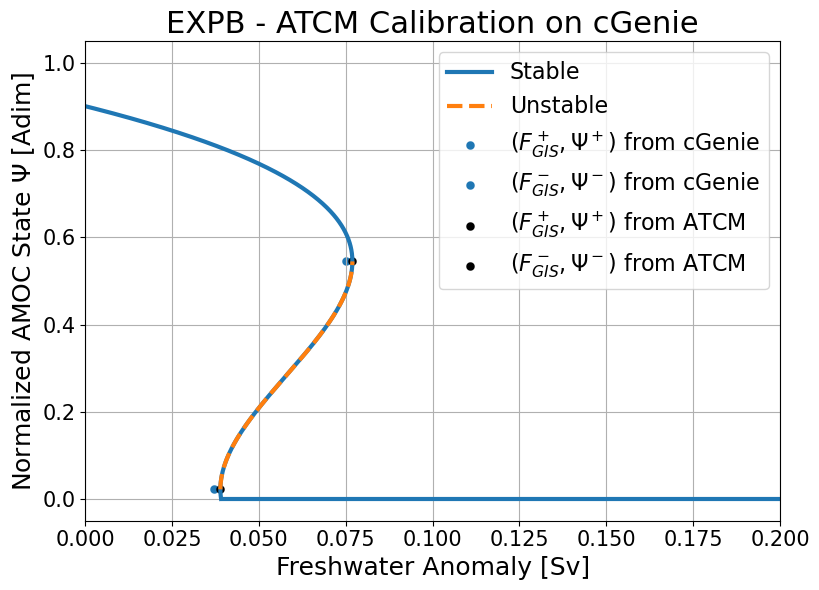

------------------------------------------------------------------------------
Difference between F_GIS^+ from cGenie and F_GIS^+ from ATCM 0.0019 Sv
Difference between F_GIS^- from cGenie and F_GIS^- from ATCM 0.0019 Sv
Relative Difference for F_GIS^+ = 2.533%
------------------------------------------------------------------------------


In [49]:
### Plot ### 
plt.figure(figsize=(8,6))

plt.plot(F_GIS_calib_module,psi_range,color='tab:blue',label='Stable',lw=3)
plt.plot(FGIS_unstable,unstable_psi,color='tab:orange',linestyle='dashed',label='Unstable',lw=3)
plt.hlines(y=0, xmin=0.039, xmax=0.2, color='tab:blue', linewidth=3)

psi_range_2 = Psip_ExpA
psi_range_3 = Psim_ExpA

plt.scatter(FGISp, Psip_ExpA, marker='o', color="#1f77b4",linewidths=0.1, label=r"$(F_{GIS}^+, \Psi^+)$ from cGenie")
plt.scatter(FGISm, Psim_ExpA, marker='o', color="#1f77b4",linewidths=0.1, label=r"$(F_{GIS}^-, \Psi^-)$ from cGenie")
plt.scatter((psi_range_2**3-a_AMOC*psi_range_2**2-b_AMOC*psi_range_2-c_AMOC-d_AMOC*T_forcing_cst_B)/e_AMOC, psi_range_2, marker='o', color="black",linewidths=0.1,label=r"$(F_{GIS}^+, \Psi^+)$ from ATCM")
plt.scatter((psi_range_3**3-a_AMOC*psi_range_3**2-b_AMOC*psi_range_3-c_AMOC-d_AMOC*T_forcing_cst_B)/e_AMOC, psi_range_3, marker='o', color="black",linewidths=0.1,label=r"$(F_{GIS}^-, \Psi^-)$ from ATCM")


plt.title("EXPB - ATCM Calibration on cGenie",fontsize=22)
plt.xlabel("Freshwater Anomaly [Sv]",fontsize=18)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=16)
plt.xlim(0,0.2)
plt.show()

print("------------------------------------------------------------------------------")
print("Difference between F_GIS^+ from cGenie and F_GIS^+ from ATCM {:.4f} Sv".format(float((psi_range_2**3-a_AMOC*psi_range_2**2-b_AMOC*psi_range_2-c_AMOC-d_AMOC*T_forcing_cst_B)/e_AMOC)-FGISp))
print("Difference between F_GIS^- from cGenie and F_GIS^- from ATCM {:.4f} Sv".format(float((psi_range_3**3-a_AMOC*psi_range_3**2-b_AMOC*psi_range_3-c_AMOC-d_AMOC*T_forcing_cst_B)/e_AMOC)-FGISm))
print("Relative Difference for F_GIS^+ = {:.3f}%".format(float((0.0019/FGISp)*100)))
print("------------------------------------------------------------------------------")

3D Forcing Space

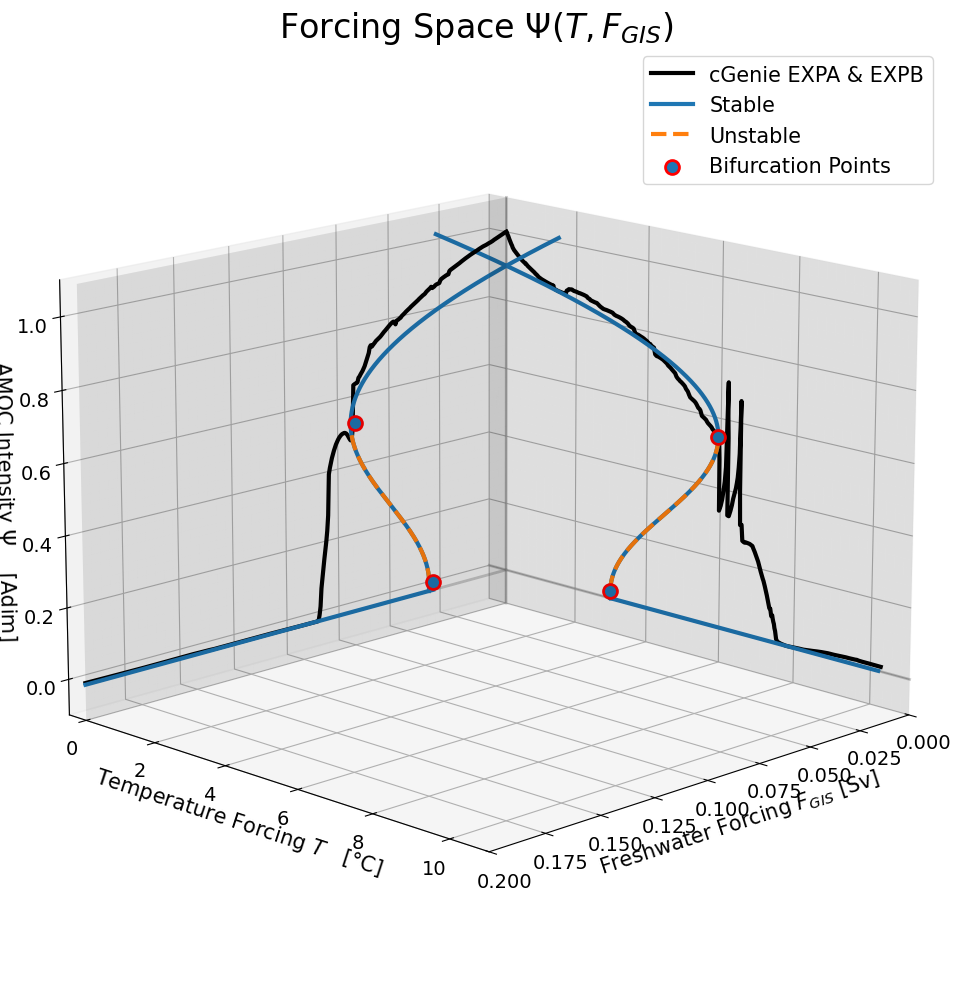

In [50]:
##### Generate data for the 3D plot #####
N = 1000
axis_F_GIS = np.linspace(0,0.2,N)
axis_T = np.linspace(-0.5,11,N)
axis_Psi = np.linspace(-0.1,1.1,N)

bif_extension = False 
psi_range = np.linspace(0,0.95,N)
T_calib_module = (psi_range**3-a_AMOC*psi_range**2-b_AMOC*psi_range-c_AMOC-e_AMOC*F_GIS_cst_A)/d_AMOC
if bif_extension:
    M = 100
    bif_ext = np.zeros(M)
    T_calib_module = np.concatenate((T_calib_module, bif_ext))
    psi_ext = np.zeros(M)
    psi_range = np.concatenate((psi_range, psi_ext))
    print(T_calib_module)
    print(len(T_calib_module))
F_GIS_calib_module = (psi_range**3-a_AMOC*psi_range**2-b_AMOC*psi_range-c_AMOC-d_AMOC*T_forcing_cst_B)/e_AMOC
unstable_psi = np.linspace(cGenie_crit_params[1],cGenie_crit_params[0],N)


##### Create a 3D plot #####
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('auto', adjustable='box')

### Plot of the axis straight lines ###
ax.plot3D(axis_F_GIS,np.zeros(N),np.zeros(N),lw=2,color='gray',alpha=0.4)
ax.plot3D(np.zeros(N),axis_T,np.zeros(N),lw=2,color='gray',alpha=0.4)
ax.plot3D(np.zeros(N),np.zeros(N),axis_Psi,lw=2,color='gray',alpha=0.4)

### Plot of 2d plans ###
## T plan ## 
plan_y = axis_T
plan_z = axis_Psi
plan_y, plan_z = np.meshgrid(plan_y,plan_z)
plan_x = np.zeros_like(plan_y)
ax.plot_surface(plan_x, plan_y, plan_z, color='black', alpha=0.1)
## F_GIS plan ## 
plan_x = axis_F_GIS
plan_z = axis_Psi
plan_x, plan_z = np.meshgrid(plan_x,plan_z)
plan_y = np.zeros_like(plan_x)
ax.plot_surface(plan_x, plan_y, plan_z, color='black', alpha=0.1)

### Plot of Temp Forcing Bifurcation Diagram (x=0) ###
ax.plot(xs=np.zeros(len(norm_atl_max_overt_ExpA)),ys=global_sat_anomaly_cGenie,zs=norm_atl_max_overt_ExpA,zdir='z',color='black',label='cGenie EXPA & EXPB',lw=3)
ax.plot(xs=np.zeros(len(T_calib_module)),ys=T_calib_module,zs=psi_range,color='tab:blue',label='Stable',lw=3)
ax.plot(xs=np.zeros(len(T_unstable)),ys=T_unstable,zs=unstable_psi,linestyle='dashed',color='tab:orange',label='Unstable',lw=3)

### Plot of F_GIS Forcing Bifurcation Diagram (y=0) ###
ax.plot(xs=hosing_forcing_it,ys=np.zeros(len(hosing_forcing_it)),zs=norm_atl_max_overt_ExpB,zdir='z',color='black',lw=3)
ax.plot(xs=F_GIS_calib_module,ys=np.zeros(len(F_GIS_calib_module)),zs=psi_range,color='tab:blue',lw=3)
ax.plot(xs=FGIS_unstable,ys=np.zeros(len(FGIS_unstable)),zs=unstable_psi,linestyle='dashed',color='tab:orange',lw=3)

### Plot of the bifurcations points ###
plot_bifu_points = True
if plot_bifu_points:
    ax.scatter(xs=0,ys=Tp,zs=Psip,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red", label='Bifurcation Points')
    ax.scatter(xs=0,ys=Tm,zs=Psim,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red")
    ax.scatter(xs=FGISp,ys=0,zs=Psip,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red")
    ax.scatter(xs=FGISm,ys=0,zs=Psim,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red")

# Plot horizontal line in the (Temperature forcing, AMOC Intensity) plane
ax.plot3D(xs=[0, 0], ys=[3, 10.2], zs=[0, 0], color='tab:blue', lw=3)

# Plot horizontal line in the (Freshwater forcing, AMOC Intensity) plane
ax.plot3D(xs=[0.037, 0.2], ys=[0, 0], zs=[0, 0], color='tab:blue', lw=3)

#### Cosmetics ####
## Add labels and title for the 3D plot ##
ax.set_xlabel('Freshwater Forcing '+r'$F_{GIS}$ [Sv]',fontsize=15)
ax.set_ylabel('Temperature Forcing '+r'$ T\quad$[°C]',fontsize=15)
ax.set_zlabel('AMOC Intensity '+r'$\Psi\quad$ [Adim]',fontsize=15)
ax.set_xlim(axis_F_GIS[0],axis_F_GIS[-1])
ax.set_ylim(axis_T[0],axis_T[-1])
ax.set_zlim(axis_Psi[0],axis_Psi[-1])
ax.set_title('Forcing Space '+r'$\Psi(T,F_{GIS})$',size=24)

#### Show the plot ####
plt.tick_params(axis='both',labelsize=14)
ax.legend(fontsize=15)
plt.tight_layout()
#ax.view_init(elev=10,azim=0) # view v1
#ax.view_init(elev=10,azim=20) # view v2
ax.view_init(elev=15,azim=45) # view v3
ax.dist = 10.5
plt.savefig(figures_path+'forcing_Space_T&FGIS',dpi=400)
plt.show()

#### 2. Calibration of $\tau$

To calibrate the time scale of the AMOC $\tau$ we will rely on time scale sensitivity experiments off cGenie and adjust the parameter $\tau$ of the AMOC in the AGTCM in order to find the best fit possible. 

##### cGenie time scale sensitivity experiment

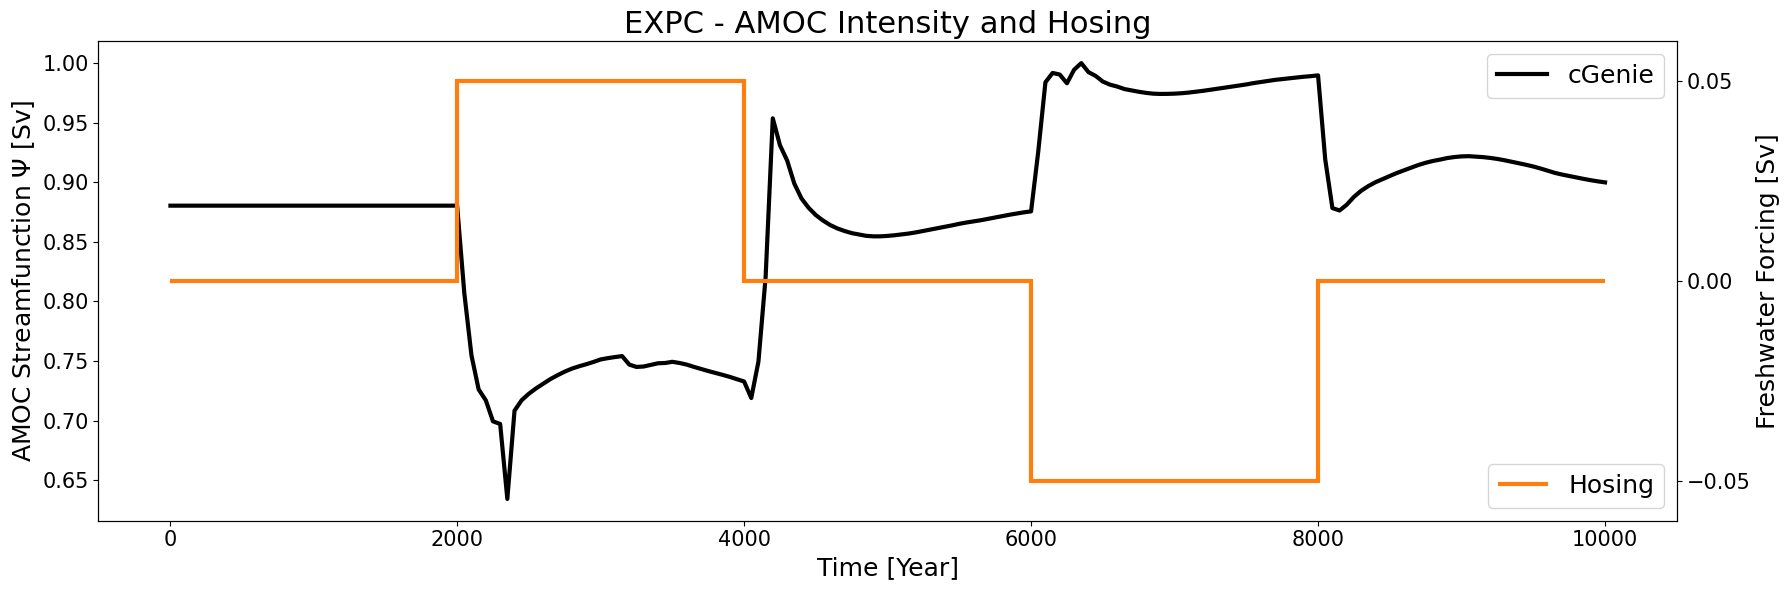

In [51]:
fig, ax1 = plt.subplots(figsize=(18,6))

ax1.plot(year_ExpC, norm_atl_max_overt_ExpC,lw=3,label="cGenie",color="black")
ax1.set_xlabel("Time [Year]",fontsize=18)
ax1.set_ylabel("AMOC Streamfunction " + r'$\Psi$ ' + "[Sv]",fontsize=18)
plt.legend(fontsize=18)
ax1.tick_params(axis='both',labelsize=15)

ax2 = ax1.twinx()

for (t_start, t_end), fgis in zip(time_intervals, FGIS_values):
    ax2.hlines(y=fgis, xmin=t_start, xmax=t_end, linewidth=3,color="tab:orange")

ax2.vlines(x=2000, ymin=-0.0005, ymax=0.0505, linewidth=3,color="tab:orange")
ax2.vlines(x=4000, ymin=-0.0005, ymax=0.0505, linewidth=3,color="tab:orange")
ax2.vlines(x=6000, ymax=0.0005, ymin=-0.0505, linewidth=3,color="tab:orange")
ax2.vlines(x=8000, ymin=0.0005, ymax=-0.0505, linewidth=3,color="tab:orange",label="Hosing")
ax2.set_ylabel("Freshwater Forcing [Sv]",fontsize=18)
ax2.set_ylim(-0.06, 0.06)
ax2.set_yticks([-0.05, 0, 0.05])
plt.legend(fontsize=18,loc='lower right')

plt.title("EXPC - AMOC Intensity and Hosing",fontsize=22)
ax2.tick_params(axis='both',labelsize=15)
plt.savefig(figures_path+'EXPC_Atl_Overt_Circ_Max_&_hosing',dpi=500)
plt.tight_layout()
plt.show()

##### ATCM calibration

First we produce the AMOC simulation based on ATCM with the same freshwater forcing.

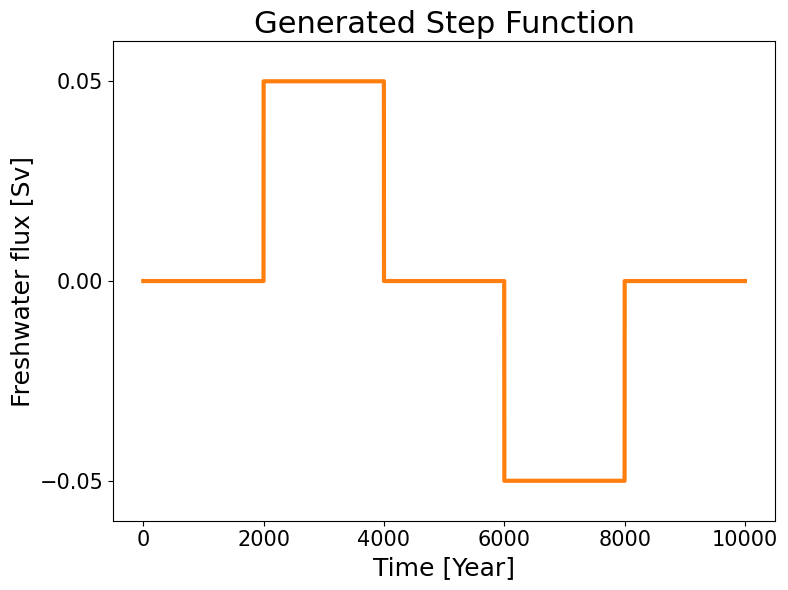

In [52]:
### Simulation Parameters ###

t0_tau_calib = 0  # year for the start of the simulation
tend_tau_calib = 10000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0_tau_calib = [0.883] # initial value 

### Parameterization of the forcing ###

# Parameterization of the temperature forcing - T constant #
T_cst = 0
forcing_temperature = interpolate.interp1d([t0_tau_calib,tend_tau_calib],[T_cst,T_cst],bounds_error= False, fill_value=0)

# Parameterization of the freshwater forcing - Step Function to replicate the one used in cGenie for EXPC #

def custom_step_function(steps=5, step_size=2000, step_values=[0, 0.05, 0, -0.05, 0]):
    """
    Generates a step function with custom values for each step.
    
    :param steps: Number of steps (levels).
    :param step_size: Length of each step.
    :param step_values: List of values to use for each step.
    :return: List representing a step function.
    """
    result = []
    for i in range(steps):
        result.extend([step_values[i]] * step_size)  # Repeat custom value for `step_size` times
    return result

step_function = custom_step_function()
time_points = np.linspace(0, 10000, 10000, endpoint=False)

# Define the interpolation function
forcing_freshwater = interpolate.interp1d(time_points, step_function, kind='previous', bounds_error=False, fill_value="extrapolate")

# Plot of the Generated Function #
plt.figure(figsize=(8,6))
plt.plot(np.arange(t0_tau_calib,tend_tau_calib),step_function,linewidth=3,color="tab:orange")
plt.title("Generated Step Function",fontsize=22)
plt.xlabel("Time [Year]", fontsize=18)
plt.ylabel("Freshwater flux [Sv]", fontsize=18)
plt.yticks([-0.05, 0, 0.05])
plt.ylim(-0.06, 0.06)
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.show()

In [53]:
### AMOC Dynamic in ATCM with cGenie Calibration ###
tau_calib = 60

def f(t, y):
    F_forcing = forcing_freshwater(t)
    T_forcing = forcing_temperature(t)

    dy = np.zeros(1)  

    dy[0] = (-y[0] ** 3 + a_AMOC * y[0] ** 2 + b_AMOC * y[0] + c_AMOC + d_AMOC * T_forcing + e_AMOC * F_forcing) / tau_calib

    return dy

n = int((tend_tau_calib - t0_tau_calib) / dt) + 1
teval = np.linspace(t0_tau_calib, tend_tau_calib, n)

sol_ExpC = solve_ivp(f, [t0_tau_calib, tend_tau_calib], y0_tau_calib, method="RK45", rtol=10**-6, t_eval=teval)

Plot of AMOC trajectory simulated by cGenie and simulated by ATCM to adjust $\tau$

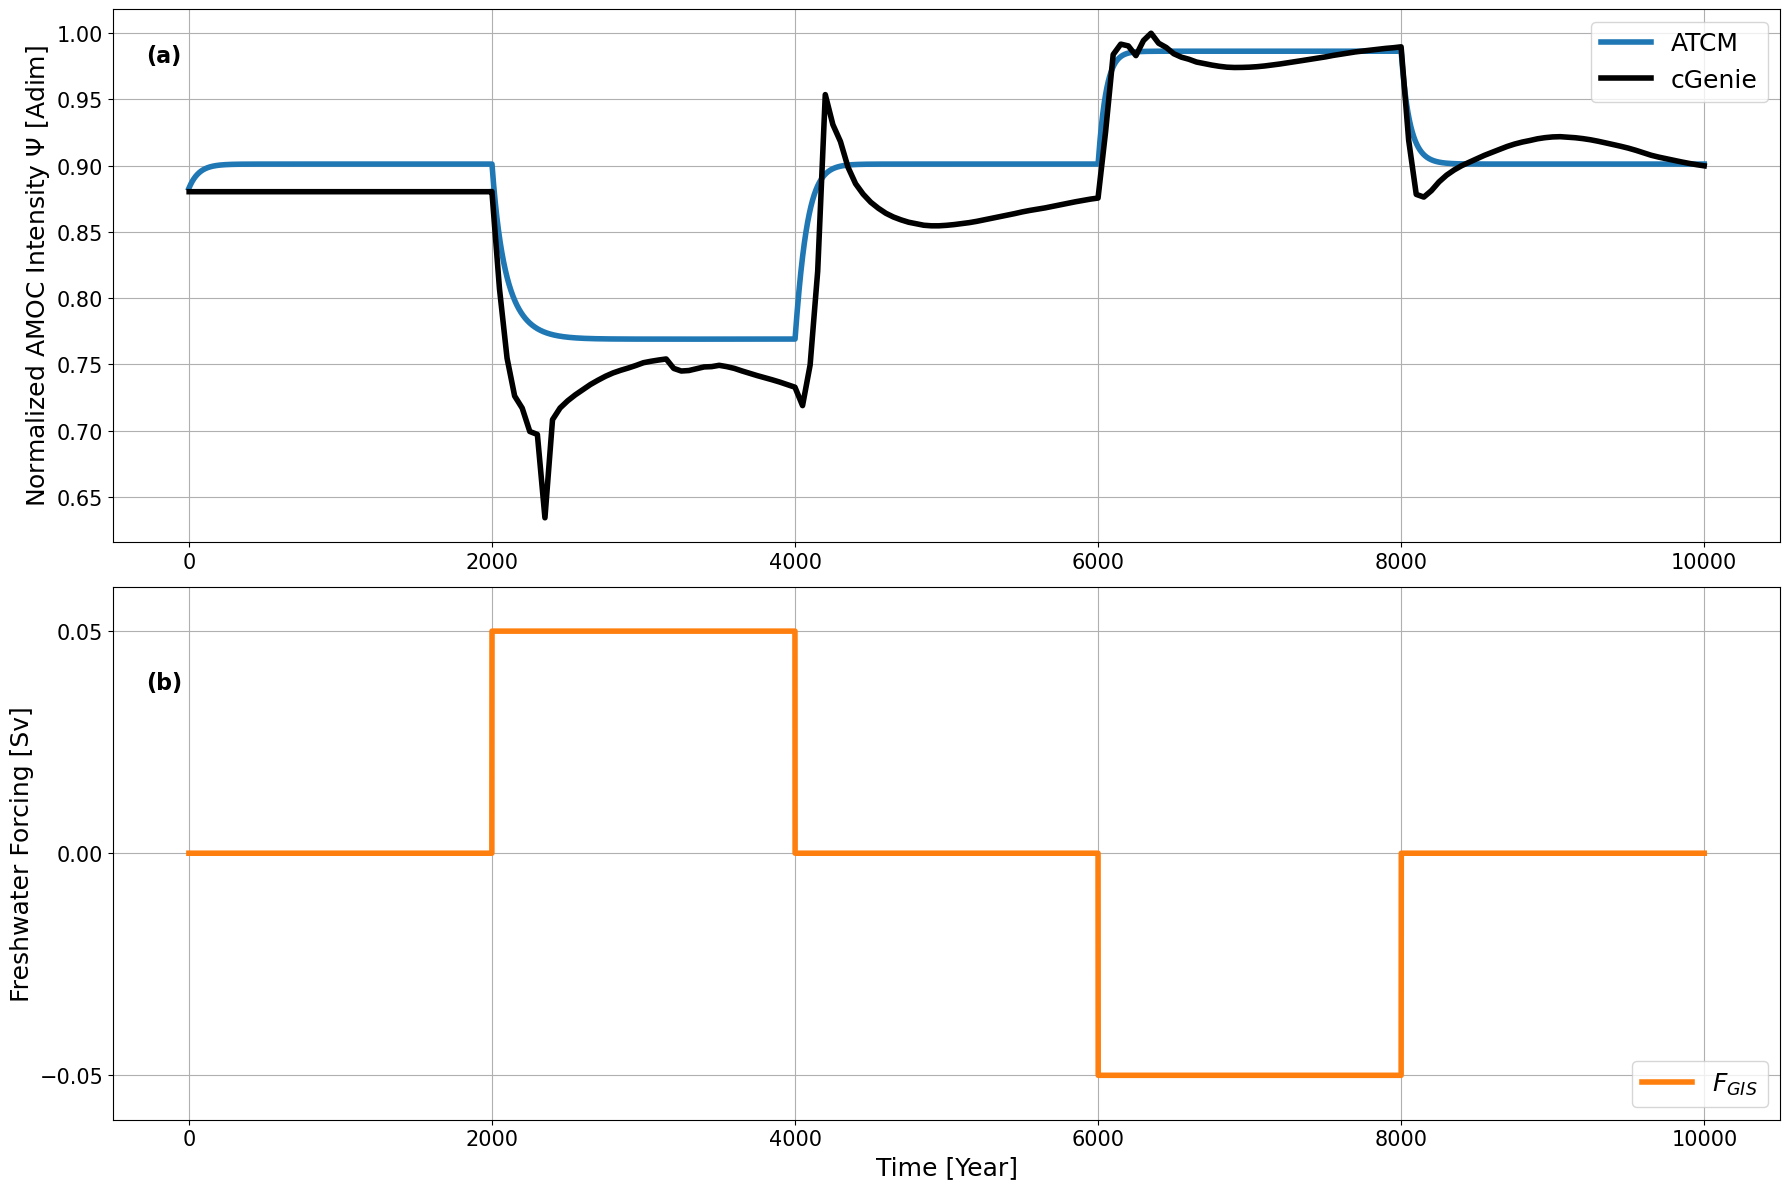

In [54]:
fig, axes = plt.subplots(2,1,figsize=(18,12))

axes[0].plot(sol_ExpC.t,sol_ExpC.y[0],lw=4,color="tab:blue",label="ATCM")
axes[0].plot(year_ExpC, norm_atl_max_overt_ExpC,lw=4,label="cGenie",color="black")
axes[0].set_ylabel("Normalized AMOC Intensity " + r'$\Psi$ ' + "[Adim]",fontsize=18)
axes[0].legend(fontsize=18)
axes[0].tick_params(axis='both',labelsize=15)
axes[0].grid()
axes[0].text(0.02, 0.90, "(a)", transform=axes[0].transAxes, fontsize=16, fontweight="bold")


axes[1].plot(np.arange(t0_tau_calib,tend_tau_calib),step_function,linewidth=4,color="tab:orange",label=r"$F_{GIS}$")
axes[1].set_ylabel("Freshwater Forcing [Sv]",fontsize=18)
axes[1].set_ylim(-0.06, 0.06)
axes[1].set_yticks([-0.05, 0, 0.05])
axes[1].legend(fontsize=18,loc='lower right')
axes[1].set_xlabel("Time [Year]",fontsize=18)
axes[1].tick_params(axis='both',labelsize=15)
axes[1].grid()
axes[1].text(0.02, -0.275, "(b)", transform=axes[0].transAxes, fontsize=16, fontweight="bold")


#plt.suptitle(r"EXPC - $\tau$ Calibration",fontsize=26)
plt.savefig(figures_path+'EXPC_tau_{}_calibration'.format(tau_calib),dpi=500)
plt.tight_layout()
plt.show()

---
## ATCM Validation
---

Here we will compare the results of the AMOC evolution in cGenie with ATCM in order to validate the capacity of the ATCM to be an emulator. For that we first rely on an hybrid forcing experiment named _hybrid collapse_ that was performed within cGenie. 

- _hybrid forcing_ : The simulation is a 20 000 years run where the forcing applied in cGenie is the combinaison of the freshwater flux forcing in the calibration experiment $EXPB$ and the temperature forcing in the calibration experiment $EXPA$. In other words, an $CO_2$ linear forcing from $280\;pmpm$ to $2800\;ppm$ has been applied and for the freshwater forcing it is a linear forcing from $0\;Sv$ to $0.2\;Sv$ in the same hosing region as before. 

### Validation Experiment 1 - _hybrid forcing_

#### Temperature Forcing

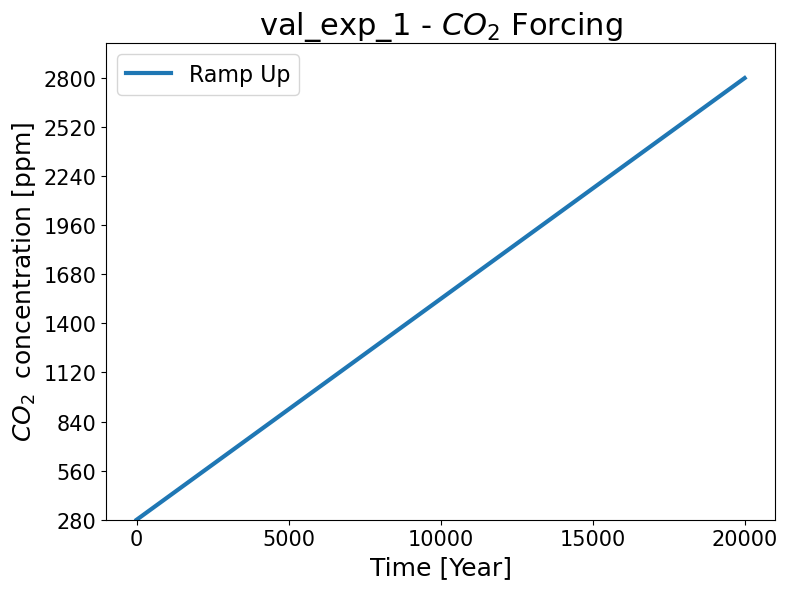

In [55]:
### Forcing parameterization ###

t_pi= 0
t_0 = 0
t_end = 20000
co2_min = 280
co2_max = 2800

time_ramp_up = np.arange(t_0,t_end,1)
time = np.arange(t_0,t_end,1)


co2_ramp_up = interpolate.interp1d([t_0,t_end],[co2_min,co2_max],bounds_error= False, fill_value=0)
co2_ramp_up_forcing = co2_ramp_up(time_ramp_up)

### Plot ###

plt.figure(figsize=(8,6))
plt.plot(time_ramp_up,co2_ramp_up_forcing,label='Ramp Up',lw=3)
#plt.plot(year_ExpA, global_pCO2*1e6)
plt.title("val_exp_1 -" + r" $CO_{2}$"+" Forcing",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel(r"$CO_2\;$ concentration [ppm]",fontsize=18)
plt.ylim(280,3000)
plt.yticks(np.arange(280, 3000, step=280))
plt.xticks(np.arange(0,25000, step=5000))
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(figures_path+'val_exp_1_CO2_forcing',dpi=500)
plt.show()

Equilibrium initial surface temperature : 12.306488 °C
Equilibrium initial surface temperature anomaly : 0       0.000000
1       0.002838
2       0.005654
3       0.006674
4       0.009192
         ...    
494    10.105883
495    10.147456
496    10.188147
497    10.229401
498    10.271215
Name: 12.302803, Length: 499, dtype: float64 °C


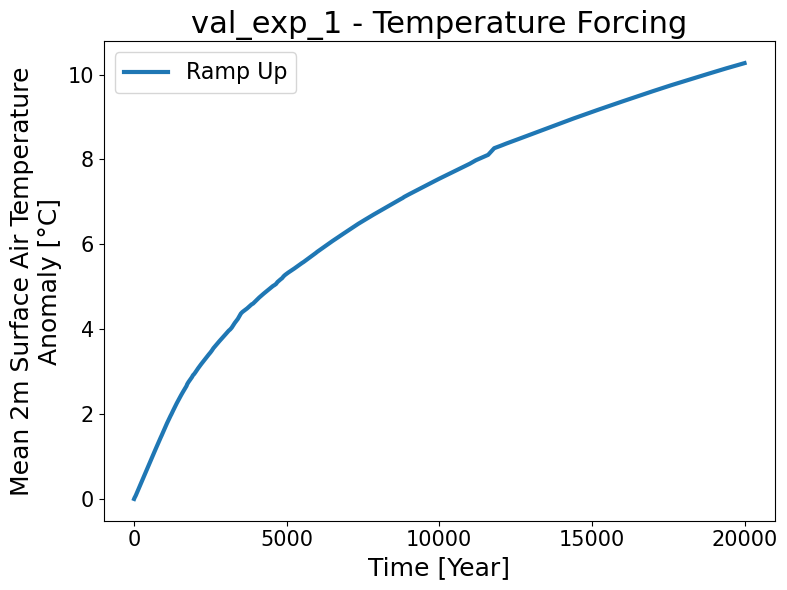

In [56]:
### Computation of the global surface temperature anomaly ###
eq_temp_cGenie = global_sat_val_exp_1[0]
global_sat_anomaly_cGenie_val_exp_1 = global_sat_val_exp_1 - eq_temp_cGenie
print("Equilibrium initial surface temperature : {} °C".format(eq_temp_cGenie))
print("Equilibrium initial surface temperature anomaly : {} °C".format(global_sat_anomaly_cGenie_val_exp_1))

plt.figure(figsize=(8,6))
plt.plot(year_val_exp_1,global_sat_anomaly_cGenie_val_exp_1,label='Ramp Up',lw=3)
plt.title("val_exp_1 - Temperature Forcing",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel("Mean 2m Surface Air Temperature\nAnomaly [°C]",fontsize=18)
plt.xticks(np.arange(0,25000, step=5000))
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.savefig(figures_path+'val_exp_1_Temp_forcing_anomaly',dpi=500)
plt.legend(fontsize=16)
plt.show()

#### Freshwater forcing

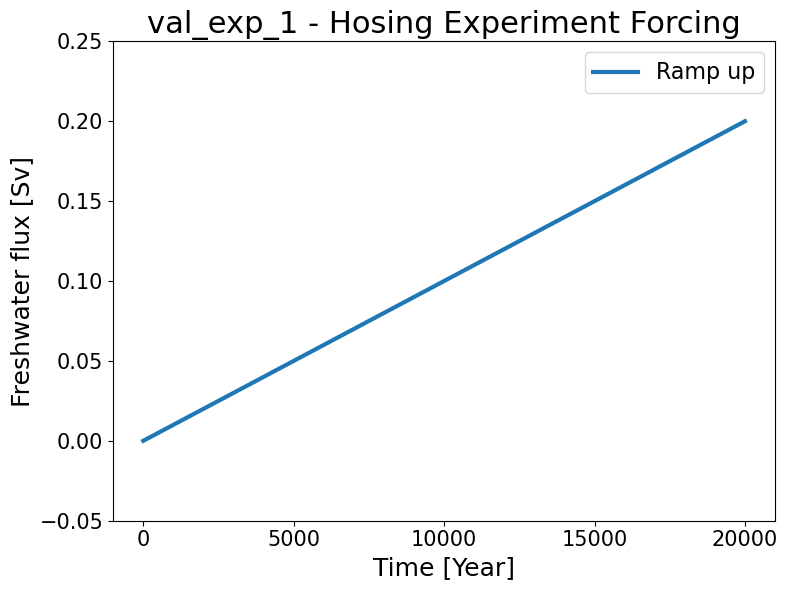

In [57]:
### Construction of the Hosing Profile ###
t_0 = 0
t_f = 20000
hosing_min = 0
hosing_max = 0.2

time_ramp_up = np.arange(t_0,t_f,1)
time = np.arange(t_0,t_f,1)

freshwater_flux_ramp_up_hosing = interpolate.interp1d([t_0,t_f],[hosing_min,hosing_max],bounds_error= False, fill_value=0)
frswat_flux_ramp_up = freshwater_flux_ramp_up_hosing(time_ramp_up)

### Plotting ### 

plt.figure(figsize=(8,6))
plt.plot(time_ramp_up,frswat_flux_ramp_up, label='Ramp up',lw=3)
plt.title("val_exp_1 - Hosing Experiment Forcing",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel("Freshwater flux [Sv]",fontsize=18)
plt.ylim(-0.05,0.25)
plt.legend(fontsize=16)
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.xticks(np.arange(0,25000, step=5000))
plt.savefig(figures_path+'val_exp_1_forcing',dpi=400)
plt.show()

#### AMOC Trajectory in cGenie and ATCM

##### AMOC in cGenie

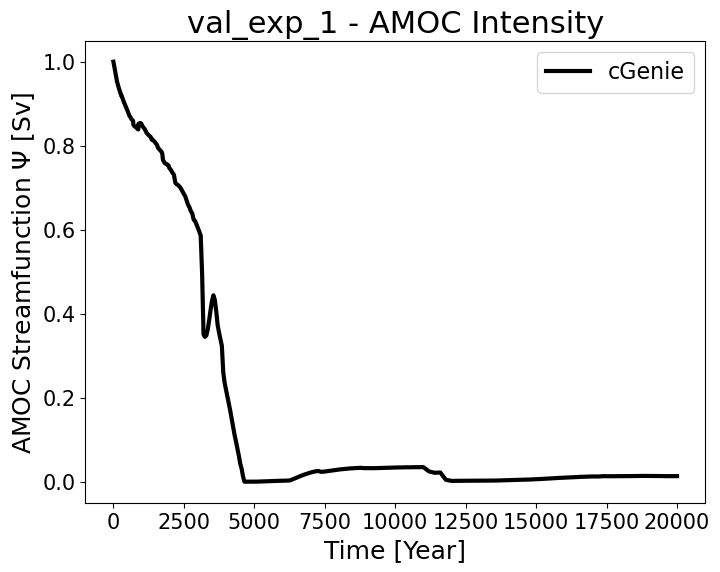

In [58]:
plt.figure(figsize=(8,6))
plt.plot(year_val_exp_1, norm_atl_max_overt_val_exp_1,lw=3,color="black",label="cGenie")
plt.title("val_exp_1 - AMOC Intensity",fontsize=22)
plt.xlabel("Time [Year]",fontsize=18)
plt.ylabel("AMOC Streamfunction " + r'$\Psi$ ' + "[Sv]",fontsize=18)
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=16)
plt.savefig(figures_path+'val_exp_1_AMOC_cGenie',dpi=500)
plt.show()

##### AMOC in ATCM

Parameterization of the forcings

In [59]:
t0 = 0  # year for the start of the simulation
tend = 20000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1.0]  # initial value

In [60]:
# Parameterization of the temperature forcing 

time_points = np.arange(len(global_sat_anomaly_cGenie_val_exp_1))  
global_sat_anomaly_cGenie_val_exp_1 = np.array(global_sat_anomaly_cGenie_val_exp_1)  
forcing_temperature_val_exp_1 = interpolate.interp1d(year_val_exp_1, global_sat_anomaly_cGenie_val_exp_1, kind='linear', bounds_error=False, fill_value="extrapolate")

# Parameterization of the freshwater forcing 
F_forcing_max = 0.2
forcing_freshwater_val_exp_1 = interpolate.interp1d([t0,tend],[0,F_forcing_max],bounds_error= False, fill_value=0)


Model for ATCM

In [61]:
###Smooth function defined in SURFER_cascades cfr. Couplet et al.(2025b) ### 

# This function is used to smooth the transition with physical relevance to avoid 
# that the state of the tipping element given by # the ATCM becomes negative. 

ky1 = 0.005
ky2 = 0.01

def smooth_trans_2(x,k1,k2):
    if x < k2 :
        if x <= k1 :
            return float('inf')
        else :
            return (x-k1)/(k2-k1)
    elif x > 1-k2 :
        if x >= 1-k1 :
            return float('inf')
        else : 
            return (x-1+k1)/(k1-k2)
    else :
        return 1

In [62]:
### AMOC Dynamic in ATCM with cGenie Calibration ###
def f(t, y):
    F_forcing = forcing_freshwater_val_exp_1(t)
    T_forcing = forcing_temperature_val_exp_1(t)

    dy = np.zeros(1)  
    tau=tau_calib #default value

    dy[0] = (-y[0] ** 3 + a_AMOC * y[0] ** 2 + b_AMOC * y[0] + c_AMOC + d_AMOC * T_forcing + e_AMOC * F_forcing)

    if (dy[0]>0 and y[0]>1-ky2) or (dy[0]<0 and y[0]<ky2) :
        tau = tau*smooth_trans_2(y[0],ky1,ky2)

    dy[0] = dy[0]/tau

    return dy

n = int((tend - t0) / dt) + 1
teval = np.linspace(t0, tend, n)

sol_val_exp_1 = solve_ivp(f, [t0, tend], y0, method="RK45", rtol=10**-6, t_eval=teval)

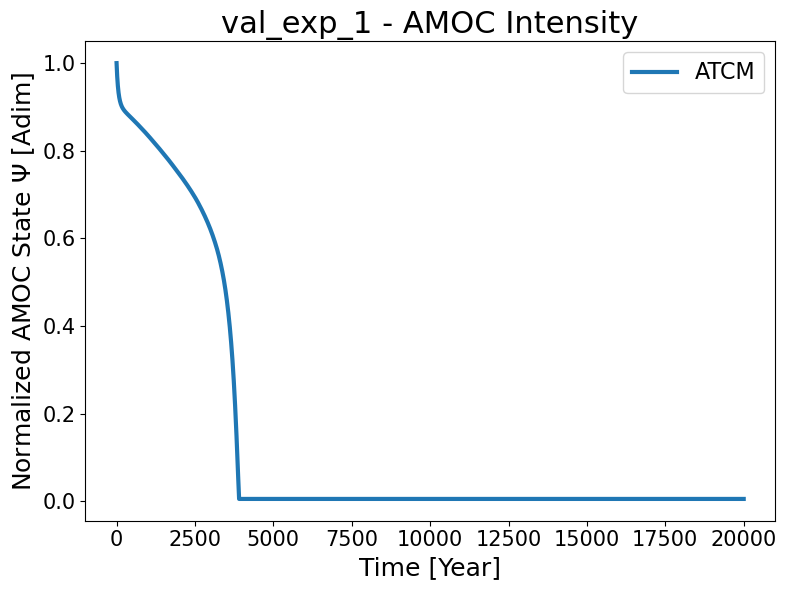

In [63]:
plt.figure(figsize=(8,6))
plt.plot(sol_val_exp_1.t,sol_val_exp_1.y[0],lw=3,color="tab:blue",label="ATCM")
plt.title("val_exp_1 - AMOC Intensity",fontsize=22)
plt.xlabel("Time [Year]", fontsize=18)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
#plt.yticks([-0.05, 0, 0.05])
#plt.ylim(-0.1, 1.1)
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(figures_path+'val_exp_1_AMOC_ATCM',dpi=500)
plt.show()

##### Validation

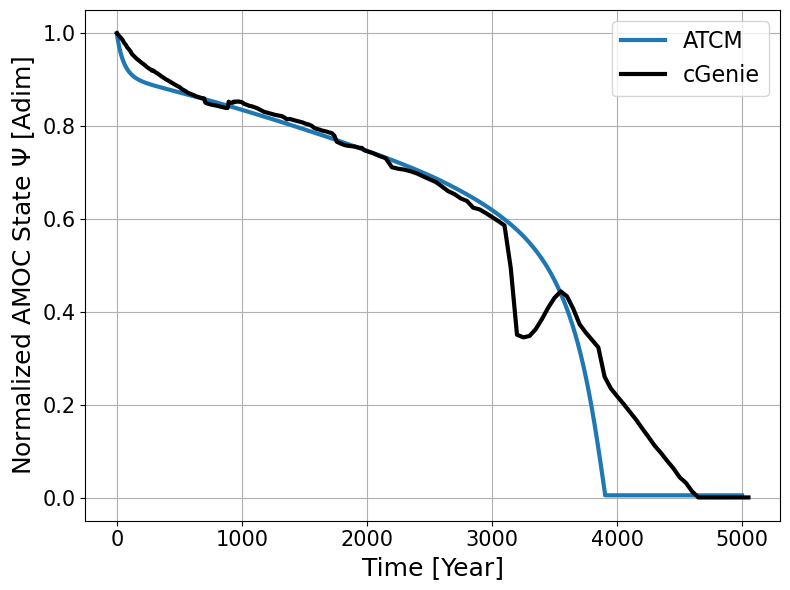

In [235]:
plt.figure(figsize=(8,6))
plt.plot(sol_val_exp_1.t[0:5000],sol_val_exp_1.y[0][0:5000],lw=3,color="tab:blue",label="ATCM")
plt.plot(year_val_exp_1[0:350], norm_atl_max_overt_val_exp_1[0:350],lw=3,color="black",label="cGenie")
#plt.title("val_exp_1 - AMOC in ATCM",fontsize=22)
plt.xlabel("Time [Year]", fontsize=18)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
#plt.yticks([-0.05, 0, 0.05])
#plt.ylim(-0.1, 1.1)
#plt.xlim([3800,4800])
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig(figures_path+'val_exp_1_validation_tau_{}'.format(tau_calib),dpi=500)
plt.show()

In [193]:
### Computation of the linear critical variety ###

T = np.linspace(0,6,499)

def w_c(T):
    return ((d_AMOC/e_AMOC)*(Tp-T))

W_C = w_c(T)

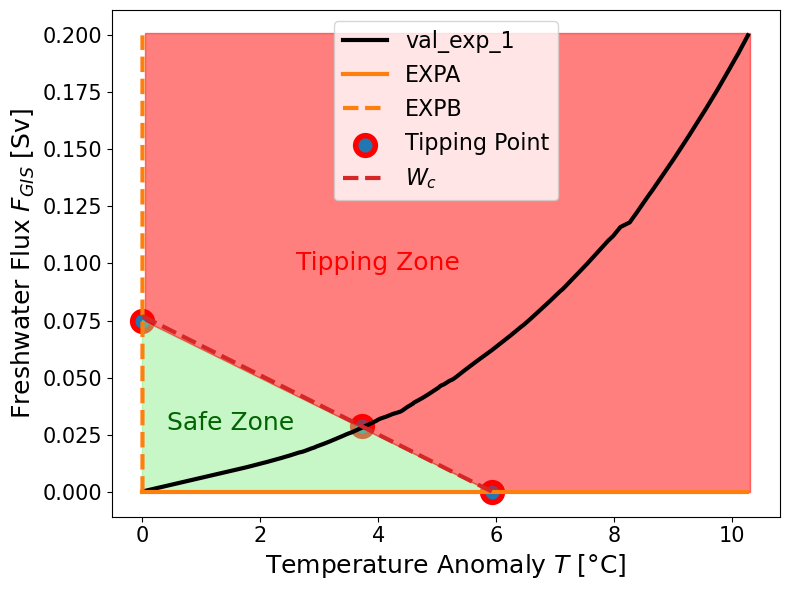

In [229]:
plt.figure(figsize=(8,6))

# Plot the orange, green, and dashed green lines
plt.plot(global_sat_anomaly_cGenie_val_exp_1, hosing_forcing_it, label='val_exp_1', lw=3, color="black")
plt.plot(global_sat_anomaly_cGenie, np.zeros(len(global_sat_anomaly_cGenie)), label='EXPA', lw=3, color="tab:orange")
plt.plot(np.zeros(len(frswat_flux_ramp_up)), frswat_flux_ramp_up, label='EXPB', lw=3, color="tab:orange", linestyle='--')

# Scatter points for Tipping Point
plt.scatter(Tp, 0, marker='o', color="#1f77b4", linewidths=4, s=200, edgecolors="red", label="Tipping Point")
plt.scatter(0, FGISp, marker='o', color="#1f77b4", linewidths=4, s=200, edgecolors="red")

# Another Tipping Point scatter
plt.scatter(3.73, 0.0288, marker='o', color="#1f77b4", linewidths=4, s=200, edgecolors="red")

# Plot the red line W_c
plt.plot(T, W_C, lw=3, color="tab:red", label="$W_c$", linestyle='--')

# # Ensure that the filled region is strictly under the red line
# W_C_interpolated = np.interp(global_sat_anomaly_cGenie_val_exp_1, np.linspace(min(global_sat_anomaly_cGenie_val_exp_1), max(global_sat_anomaly_cGenie_val_exp_1), len(W_C)), W_C)
# plt.fill_between(global_sat_anomaly_cGenie_val_exp_1, np.zeros(len(global_sat_anomaly_cGenie_val_exp_1)), W_C_interpolated, 
#                  color="lightgreen", alpha=0.5, where=(W_C_interpolated >= 0))  # Fill only where W_C >= 0

x = [0, Tp, 0]
y = [0, 0, FGISp]

i = [Tp, 10.3, 10.3,0.05,0.05]
j = [0, 0, 0.201,0.201,0.075]

# Remplir la surface du triangle
plt.fill(x, y, color="lightgreen", alpha=0.5)
plt.fill(i, j, color="red", alpha=0.5)

# Adding the text "safe zone" in the middle of the filled region
# Positioning the text in the middle of the green shaded area
plt.text(1.5,0.03,"Safe Zone", color="darkgreen", fontsize=18, ha="center", va="center")
plt.text(4,0.1,"Tipping Zone", color="red", fontsize=18, ha="center", va="center")

# Set title and labels
#plt.title("Validation Experiment in Forcing Space " + r"$(T,F_{GIS})$", fontsize=22)
plt.xlabel("Temperature Anomaly $T$ [°C]", fontsize=18)
plt.ylabel("Freshwater Flux " + r"$F_{GIS}$ [Sv]", fontsize=18)

# Customize ticks and legend
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=16)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(figures_path + 'val_exp_1_safe_zone', dpi=500)
plt.show()


---
## Supplementary Tests
---

### Test Overshoot

In [104]:
t0 = 0  # year for the start of the simulation
tend = 20000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1.0]  # initial value

In [177]:
# Parameterization of the temperature forcing 

# Longueur de la liste
length = 20001

# Point spécifique où la valeur sera Tp
index_tp = 10000  # Par exemple, au milieu de la liste

# Construction de la liste
forcing_temp_over_test = [Tp] * length
for index_tp in range(6000,6300):
    forcing_temp_over_test[index_tp] = (Tp*1+(0.1*Tp))
forcing_temperature_over_test = interpolate.interp1d(np.linspace(t0,tend,length), forcing_temp_over_test, kind='linear', bounds_error=False, fill_value="extrapolate")


# Parameterization of the freshwater forcing 
F_forcing_max = 0
forcing_freshwater_over_test = interpolate.interp1d([t0,tend],[0,0],bounds_error= False, fill_value=0)


In [178]:
### AMOC Dynamic in ATCM with cGenie Calibration ###
def f(t, y):
    F_forcing = forcing_freshwater_over_test(t)
    T_forcing = forcing_temperature_over_test(t)

    dy = np.zeros(1)  
    tau=tau_calib #default value

    dy[0] = (-y[0] ** 3 + a_AMOC * y[0] ** 2 + b_AMOC * y[0] + c_AMOC + d_AMOC * T_forcing + e_AMOC * F_forcing)

    if (dy[0]>0 and y[0]>1-ky2) or (dy[0]<0 and y[0]<ky2) :
        tau = tau*smooth_trans_2(y[0],ky1,ky2)

    dy[0] = dy[0]/tau

    return dy

n = int((tend - t0) / dt) + 1
teval = np.linspace(t0, tend, n)

sol_over_test = solve_ivp(f, [t0, tend], y0, method="RK45", rtol=10**-6, t_eval=teval)

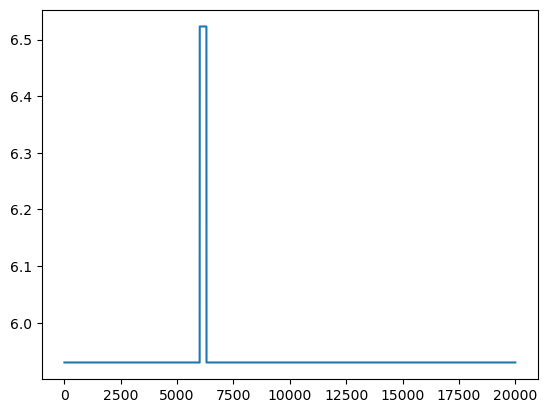

In [179]:
plt.plot(sol_over_test.t,forcing_temp_over_test)

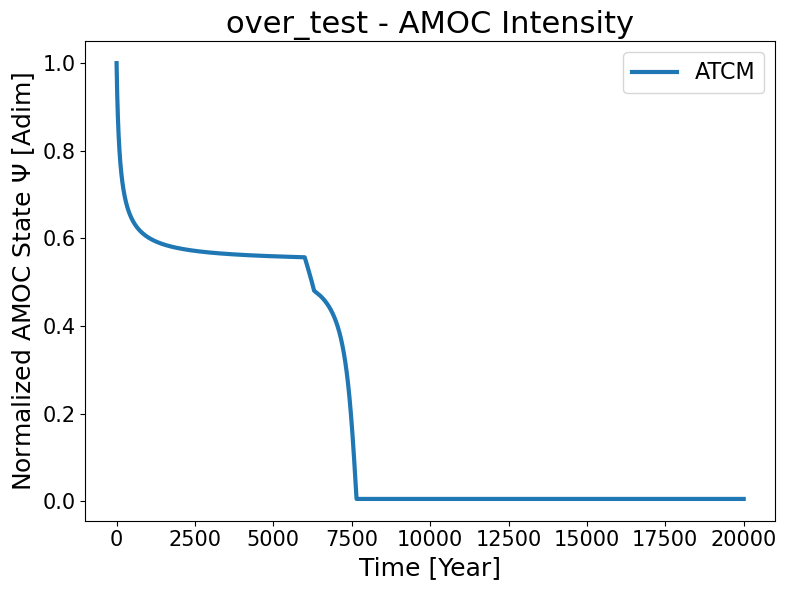

In [180]:
plt.figure(figsize=(8,6))
plt.plot(sol_over_test.t,sol_over_test.y[0],lw=3,color="tab:blue",label="ATCM")
plt.title("over_test - AMOC Intensity",fontsize=22)
plt.xlabel("Time [Year]", fontsize=18)
plt.ylabel("Normalized AMOC State "+r"$\Psi$ "+"[Adim]",fontsize=18)
#plt.yticks([-0.05, 0, 0.05])
#plt.ylim(-0.1, 1.1)
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(figures_path+'over_test_AMOC_ATCM',dpi=500)
plt.show()

### Bifurcation Diagram

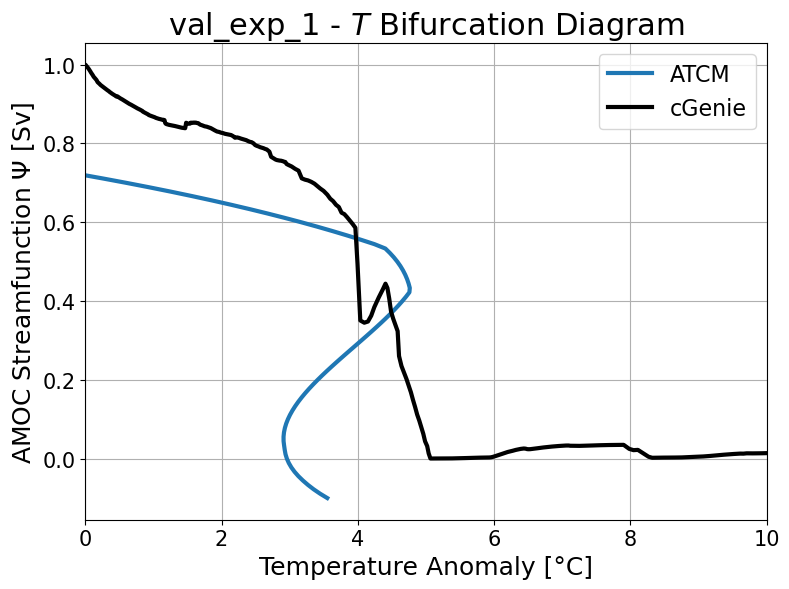

In [ ]:
y_range = np.linspace(-0.1,1.0,100)

x_hosing = np.linspace(0, 1, len(hosing_forcing_it))  

# Interpolation pour adapter à la longueur de y_range
F = np.interp(np.linspace(0, 1, len(y_range)), x_hosing, hosing_forcing_it)

T_calib_module = (y_range**3-a_AMOC*y_range**2-b_AMOC*y_range-c_AMOC-e_AMOC*F)/d_AMOC


plt.figure(figsize=(8,6))
plt.plot(T_calib_module,y_range,lw=3,label='ATCM',color="tab:blue")
#plt.plot(global_sat_anomaly_cGenie_val_exp_1, interp_sol_val_exp_1,label='ATCM',lw=3,color="tab:blue")
plt.plot(global_sat_anomaly_cGenie_val_exp_1,norm_atl_max_overt_val_exp_1,label="cGenie",color="black",lw=3)
plt.title("val_exp_1 - $T$ Bifurcation Diagram",fontsize=22)
plt.xlabel("Temperature Anomaly [°C]",fontsize=18)
plt.xlim([0,10])
plt.ylabel("AMOC Streamfunction " + r'$\Psi$ ' + "[Sv]",fontsize=18)
plt.legend(fontsize=16)
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()
plt.grid()
plt.savefig(figures_path+'val_exp_1_bif_diag_T',dpi=400)
plt.show()

### Test Retrieve Intersection $W_c$ val_exp_1

In [ ]:
# ### Find the moment in forcing simulation associated to the tipping point in ATCM ###

# interp_hosing_forcing_it = interpolate.interp1d()

# eps = 0.01
# for i in range(len(global_sat_anomaly_cGenie_val_exp_1)):
#     if (hosing_forcing_it[i] - ((d_AMOC/e_AMOC)*(Tp-global_sat_anomaly_cGenie_val_exp_1[i])))<eps:
#         print(i)


### Test 3D Plot

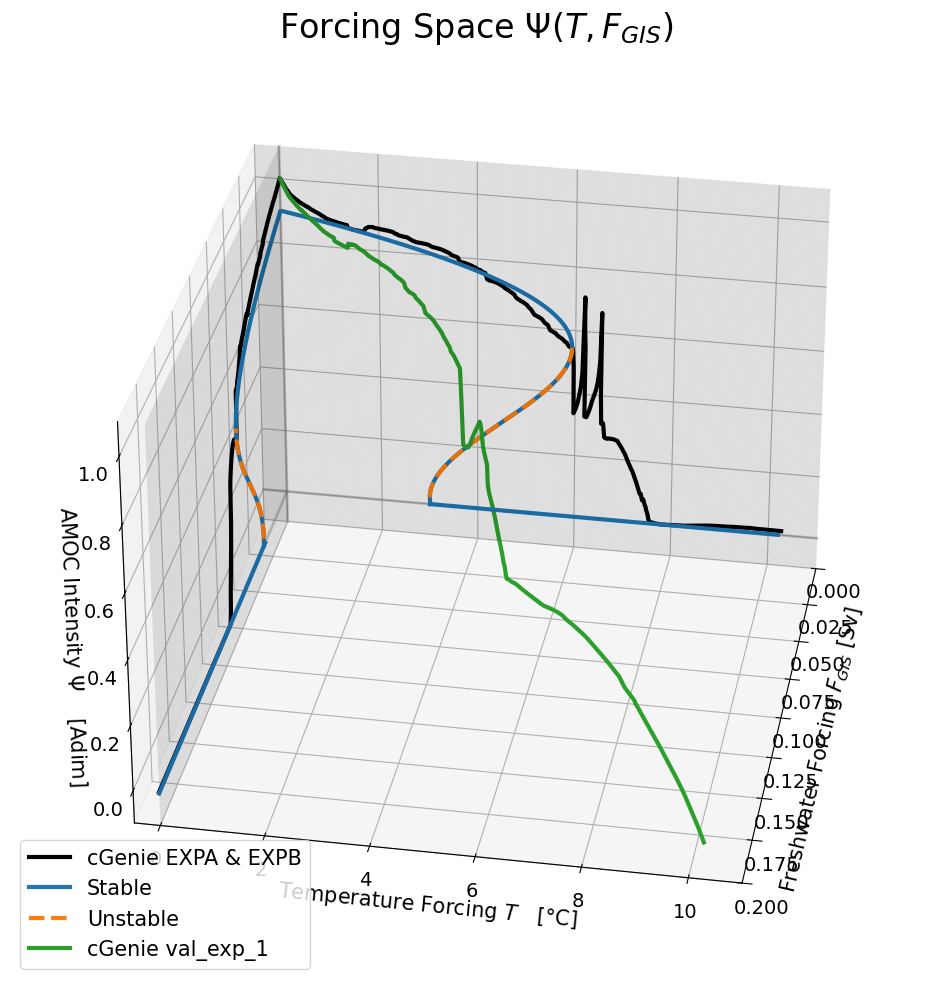

In [ ]:
##### Generate data for the 3D plot #####
N = 1000
axis_F_GIS = np.linspace(0,0.2,N)
axis_T = np.linspace(-0.5,11,N)
axis_Psi = np.linspace(-0.1,1.1,N)

bif_extension = False 
psi_range = np.linspace(0,0.90,N)
T_calib_module = (psi_range**3-a_AMOC*psi_range**2-b_AMOC*psi_range-c_AMOC-e_AMOC*F_GIS_cst_A)/d_AMOC
if bif_extension:
    M = 100
    bif_ext = np.zeros(M)
    T_calib_module = np.concatenate((T_calib_module, bif_ext))
    psi_ext = np.zeros(M)
    psi_range = np.concatenate((psi_range, psi_ext))
    print(T_calib_module)
    print(len(T_calib_module))
F_GIS_calib_module = (psi_range**3-a_AMOC*psi_range**2-b_AMOC*psi_range-c_AMOC-d_AMOC*T_forcing_cst_B)/e_AMOC
unstable_psi = np.linspace(cGenie_crit_params[1],cGenie_crit_params[0],N)


##### Create a 3D plot #####
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('auto', adjustable='box')

### Plot of the axis straight lines ###
ax.plot3D(axis_F_GIS,np.zeros(N),np.zeros(N),lw=2,color='gray',alpha=0.4)
ax.plot3D(np.zeros(N),axis_T,np.zeros(N),lw=2,color='gray',alpha=0.4)
ax.plot3D(np.zeros(N),np.zeros(N),axis_Psi,lw=2,color='gray',alpha=0.4)

### Plot of 2d plans ###
## T plan ## 
plan_y = axis_T
plan_z = axis_Psi
plan_y, plan_z = np.meshgrid(plan_y,plan_z)
plan_x = np.zeros_like(plan_y)
ax.plot_surface(plan_x, plan_y, plan_z, color='black', alpha=0.1)
## F_GIS plan ## 
plan_x = axis_F_GIS
plan_z = axis_Psi
plan_x, plan_z = np.meshgrid(plan_x,plan_z)
plan_y = np.zeros_like(plan_x)
ax.plot_surface(plan_x, plan_y, plan_z, color='black', alpha=0.1)

### Plot of Temp Forcing Bifurcation Diagram (x=0) ###
ax.plot(xs=np.zeros(len(norm_atl_max_overt_ExpA)),ys=global_sat_anomaly_cGenie,zs=norm_atl_max_overt_ExpA,zdir='z',color='black',label='cGenie EXPA & EXPB',lw=3)
ax.plot(xs=np.zeros(len(T_calib_module)),ys=T_calib_module,zs=psi_range,color='tab:blue',label='Stable',lw=3)
ax.plot(xs=np.zeros(len(T_unstable)),ys=T_unstable,zs=unstable_psi,linestyle='dashed',color='tab:orange',label='Unstable',lw=3)

### Plot of F_GIS Forcing Bifurcation Diagram (y=0) ###
ax.plot(xs=hosing_forcing_it,ys=np.zeros(len(hosing_forcing_it)),zs=norm_atl_max_overt_ExpB,zdir='z',color='black',lw=3)
ax.plot(xs=F_GIS_calib_module,ys=np.zeros(len(F_GIS_calib_module)),zs=psi_range,color='tab:blue',lw=3)
ax.plot(xs=FGIS_unstable,ys=np.zeros(len(FGIS_unstable)),zs=unstable_psi,linestyle='dashed',color='tab:orange',lw=3)

### Plot of val_exp_1 ###
ax.plot(xs=hosing_forcing_it,ys=global_sat_anomaly_cGenie_val_exp_1,zs=norm_atl_max_overt_val_exp_1,zdir='z',color='tab:green',lw=3,label="cGenie val_exp_1")

# time_points = np.arange(len(sol_val_exp_1.y[0]))  
# #global_sat_anomaly_cGenie_val_exp_1 = np.array(global_sat_anomaly_cGenie_val_exp_1)  
# sol_val_exp_1_interp_func = interpolate.interp1d(time_points, sol_val_exp_1.y[0], kind='linear', bounds_error=False, fill_value="extrapolate")
# sol_val_exp_1_interp_list = sol_val_exp_1_interp_func(global_sat_anomaly_cGenie_val_exp_1)

# ax.plot(xs=hosing_forcing_it,ys=global_sat_anomaly_cGenie_val_exp_1,zs=sol_val_exp_1_interp_list,color='tab:green',lw=3)

### Plot of the bifurcations points ###
plot_bifu_points = False
if plot_bifu_points:
    ax.scatter(xs=0,ys=Tp,zs=Psip,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red", label='Bifurcation Points')
    ax.scatter(xs=0,ys=Tm,zs=Psim,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red")
    ax.scatter(xs=FGISp,ys=0,zs=Psip,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red")
    ax.scatter(xs=FGISm,ys=0,zs=Psim,marker='o', color="#1f77b4",linewidths=2,s=100, edgecolors="red")

# Plot horizontal line in the (Temperature forcing, AMOC Intensity) plane
ax.plot3D(xs=[0, 0], ys=[3, 10.2], zs=[0, 0], color='tab:blue', lw=3)

# Plot horizontal line in the (Freshwater forcing, AMOC Intensity) plane
ax.plot3D(xs=[0.037, 0.2], ys=[0, 0], zs=[0, 0], color='tab:blue', lw=3)

#### Cosmetics ####
## Add labels and title for the 3D plot ##
ax.set_xlabel('Freshwater Forcing '+r'$F_{GIS}$ [Sv]',fontsize=15)
ax.set_ylabel('Temperature Forcing '+r'$ T\quad$[°C]',fontsize=15)
ax.set_zlabel('AMOC Intensity '+r'$\Psi\quad$ [Adim]',fontsize=15)
ax.set_xlim(axis_F_GIS[0],axis_F_GIS[-1])
ax.set_ylim(axis_T[0],axis_T[-1])
ax.set_zlim(axis_Psi[0],axis_Psi[-1])
ax.set_title('Forcing Space '+r'$\Psi(T,F_{GIS})$',size=24)

#### Show the plot ####
plt.tick_params(axis='both',labelsize=14)
ax.legend(fontsize=15)
plt.tight_layout()
#ax.view_init(elev=10,azim=0) # view v1
ax.view_init(elev=30,azim=10) # view v2
#ax.view_init(elev=15,azim=45) # view v3
ax.dist = 10.5
plt.savefig(figures_path+'forcing_Space_T&FGIS',dpi=400)
plt.show()